<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" alt="logoFIUBA" width="600">


## Alumno
- Denardi, Fabricio
- Perez Winter, Alan Erik
- Pertierra, Valentín

# Carrera
Maestría en Inteligencia Artificial

## Cohorte
01-2025

# Materia
Análisis de Serie de Tiempo I

# Consigna
Puede ver la consigna completa [aquí](TP_final_AST_01MA2025.pdf).



# Dataset de estudio elegido
# Real Traffic Prediction Dataset (Conjunto de datos para la predicción de tráfico real) 
## Fuente
https://www.kaggle.com/datasets/hasibullahaman/traffic-prediction-dataset?select=TrafficTwoMonth.csv

### Nota
Debido a que el dataset se actualiza muy frecuentemente, optamos por trabajar con una versión local con fecha 15-04-2025. Los datos pueden consultarse en este [link](dataset/TrafficTwoMonth.csv).

# Pregunta de investigación
¿Podemos predecir la cantidad de vehículos en un determinado día y horario? Como pregunta complementaria. Estableciendo de antemano ciertos umbrales del estádo del tráfico, ¿podemos seguerir recomendar o evitar el uso de la autopista en análisis en dicho instante de tiempo?

# Preparación de los datos

## Entendiendo el dataset
Este conjunto de datos aborda los problemas comunes de congestión vehicular en áreas urbanas. Fue creado mediante un modelo de visión por computadora que detecta cuatro tipos de vehículos: autos, motos, autobuses y camiones (el análisis del modelo de visión por computadores queda fuera del alcance de estudio). 

La información se guarda en un archivo CSV que incluye columnas como la hora, fecha, día de la semana y el conteo de cada tipo de vehículo. También contiene una columna con el total de vehículos detectados en intervalos de 15 minutos. 

Además, el dataset clasifica el estado del tráfico en cuatro niveles:
1. Bajo.
2. Normal.
3. Alto.
4. Pesado.

El dataset, actualizado cada 15 minutos durante un mes, es útil para analizar patrones de tráfico, planificar el transporte, gestionar la congestión e identificar zonas problemáticas. Permite tomar decisiones informadas sobre mejoras en la infraestructura urbana, optimización de semáforos y diseño de carriles. También apoya investigaciones sobre comportamiento del tráfico y planificación urbana sostenible.

## Importar el dataset y prepararlo para el análisis

### Librerías Python a utilizar

In [201]:
%pip install pmdarima --quiet

Note: you may need to restart the kernel to use updated packages.


In [202]:
import pandas as pd
import numpy as np 

from ydata_profiling import ProfileReport

import datetime
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [203]:
from pmdarima.arima import auto_arima

In [204]:
%matplotlib inline

In [205]:
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts 

from statsmodels.graphics.tsaplots import plot_predict

In [206]:
# Librerías de sklearn y keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score,  precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_percentage_error


In [207]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM

from keras.preprocessing.sequence import TimeseriesGenerator

### Importar dataset

In [208]:
dataset_path = os.path.join(os.getcwd(),"dataset","Traffic.csv")
print (f'El dataset está ubicado en: {dataset_path}')

El dataset está ubicado en: /Users/fabricio.denardi/Documents/CEIA/AST1/repos/MIA_c01_AST1/dataset/Traffic.csv


In [209]:
traffic_data = pd.read_csv(dataset_path)

### Veamos algunas filas para entender los datos

In [210]:
traffic_data.head(10)

Time  Date Day of the week  CarCount  BikeCount  BusCount  \
0  12:00:00 AM    10         Tuesday        31          0         4   
1  12:15:00 AM    10         Tuesday        49          0         3   
2  12:30:00 AM    10         Tuesday        46          0         3   
3  12:45:00 AM    10         Tuesday        51          0         2   
4   1:00:00 AM    10         Tuesday        57          6        15   
5   1:15:00 AM    10         Tuesday        44          0         5   
6   1:30:00 AM    10         Tuesday        37          0         1   
7   1:45:00 AM    10         Tuesday        42          4         4   
8   2:00:00 AM    10         Tuesday        51          0         9   
9   2:15:00 AM    10         Tuesday        34          0         4   

   TruckCount  Total Traffic Situation  
0           4     39               low  
1           3     55               low  
2           6     55               low  
3           5     58               low  
4          16     94            normal  
5           4     53               low  
6           4     42               low  
7           5     55               low  
8           7     67               low  
9           7     45               low

Ya podemos ir viendo algunos procesamientos que tenemos que ir haciendo, como transformar Time y Date en una única columna. Más adelante lo haremos para poder construir nuestros modelos adecuadamente.

La columna Day of the week no aporta valor, ya que puede ser calculada luego a partir de la fecha-hora construida. 

### Algunas estadísticas básicas

In [211]:
print(traffic_data.describe())
print(traffic_data.info())

              Date     CarCount    BikeCount     BusCount   TruckCount  \
count  2976.000000  2976.000000  2976.000000  2976.000000  2976.000000   
mean     16.000000    68.696573    14.917339    15.279570    15.324933   
std       8.945775    45.850693    12.847518    14.341986    10.603833   
min       1.000000     6.000000     0.000000     0.000000     0.000000   
25%       8.000000    19.000000     5.000000     1.000000     6.000000   
50%      16.000000    64.000000    12.000000    12.000000    14.000000   
75%      24.000000   107.000000    22.000000    25.000000    23.000000   
max      31.000000   180.000000    70.000000    50.000000    40.000000   

             Total  
count  2976.000000  
mean    114.218414  
std      60.190627  
min      21.000000  
25%      55.000000  
50%     109.000000  
75%     164.000000  
max     279.000000  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2976 entries, 0 to 2975
Data columns (total 9 columns):
 #   Column             Non-Null Count

#### Análisis de los estadísticos mostrados
Una de las cosas más importante que vemos acá es que no hay valores nulos que puedan hacer ruido en nuestro modelo. El dataset está muy limpio y prolijo.



## Reportes avanzados
Vamos a valernos de la libería *ydata_profiling* para tener un conjunto de reportes avanzados que podrán ayudarnos a tomar decisiones durante este trabajo práctico.

Esta librería es muy útil para tener una visualización general de los datos. Es muy clara y a la vez completa.

In [212]:
profilingreport = ProfileReport(traffic_data, title='Análisis del tráfico', minimal=True)
profilingreport

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:00<00:00, 134816.91it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Análisis de los datos
1. Podemos ver que hay observaciones para todos los días de la semana.

2. Las alertas que menciona son de Count = 0, que en el contexto de este problema no suponen un problema, ya que son de un tipo de vehículo en particular y no del Total. De haber Total = 0 nos daría indicio de que hago anda mal, o que se trata de un corte por protestas, accidente, mantenimiento.

## Transformación de datos
Como ya hemos mencionado, tenemos la fecha dividida en 2 columnas. Por un lado tenemos la hora (cada 15 minutos) en la columna 'Time', por el otro, en la columna Date, tenemos el día del mes. No temos el mes, asumimos, dado la frecuencia de actualización, que se trata de marzo, el último mes completo.

In [213]:
TOP_CURRENT_MONTH = 10
MONTH_OF_ANALYSIS = 3
YEAR_OF_ANALYSIS = 2025

In [214]:
traffic_data['Datetime'] = pd.to_datetime(
    traffic_data['Date'].astype(str) + '-' + str(MONTH_OF_ANALYSIS) + '-' + str(YEAR_OF_ANALYSIS) + ' ' + traffic_data['Time'],
    format='%d-%m-%Y %I:%M:%S %p'
)

# Ajustar el mes condicionalmente
traffic_data['Datetime'] = traffic_data['Datetime'] + np.where(
    traffic_data['Datetime'].dt.day < TOP_CURRENT_MONTH,
    pd.DateOffset(months=1),  # Desplazar un mes
    pd.DateOffset(months=0)   # No desplazar
)

/var/folders/h0/qqbs9kr17cvg14gkx_xt31fm0000gn/T/ipykernel_13897/2451785873.py:7: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  traffic_data['Datetime'] = traffic_data['Datetime'] + np.where(


In [215]:
traffic_data = traffic_data.drop(columns=['Date', 'Time', 'Day of the week'])

In [216]:
traffic_data.head(5)

CarCount  BikeCount  BusCount  TruckCount  Total Traffic Situation  \
0        31          0         4           4     39               low   
1        49          0         3           3     55               low   
2        46          0         3           6     55               low   
3        51          0         2           5     58               low   
4        57          6        15          16     94            normal   

              Datetime  
0  2025-03-10 00:00:00  
1  2025-03-10 00:15:00  
2  2025-03-10 00:30:00  
3  2025-03-10 00:45:00  
4  2025-03-10 01:00:00

In [217]:
traffic_data.tail(5)

CarCount  BikeCount  BusCount  TruckCount  Total Traffic Situation  \
2971        16          3         1          36     56            normal   
2972        11          0         1          30     42            normal   
2973        15          4         1          25     45            normal   
2974        16          5         0          27     48            normal   
2975        14          3         1          15     33            normal   

                 Datetime  
2971  2025-04-09 22:45:00  
2972  2025-04-09 23:00:00  
2973  2025-04-09 23:15:00  
2974  2025-04-09 23:30:00  
2975  2025-04-09 23:45:00

Vemos que la columna Datetime quedo formada por la columna día del mes y el Time. Notar que se hizo una operatoria agregando un mes. Esto es porque, de acuerdo a la fuente del dataset, estamos analizando un mes completo. No tenemos el mes en la fila. Como se actualiza constantemente asumimos que es el mes anterior y elcurso (comienza un día 10 y finaliza un 9).

# Análisis previo de las series de tiempo
Vamos a analizar primero como se comportan algunas de las variables (cantidad de los vehículos durante el tiempo)

In [218]:
unique_traffic_situations = traffic_data['Traffic Situation'].unique()
print(unique_traffic_situations)

['low' 'normal' 'heavy' 'high']


In [219]:
# Crear un diccionario para mapear las categorías a valores numéricos
traffic_situation_mapping = {'low': 1, 'normal': 2, 'high': 3, 'heavy': 4}
reverse_traffic_situation_mapping = {v: k for k, v in traffic_situation_mapping.items()}


In [220]:
print(traffic_situation_mapping)
print(reverse_traffic_situation_mapping)

{'low': 1, 'normal': 2, 'high': 3, 'heavy': 4}
{1: 'low', 2: 'normal', 3: 'high', 4: 'heavy'}


In [221]:

traffic_situation_colors = {
    'low': 'green',
    'normal': 'yellow',
    'high': 'orange',
    'heavy': 'red'
}

# Crear la nueva columna con los valores numéricos
traffic_data['TrafficStatus'] = traffic_data['Traffic Situation'].map(traffic_situation_mapping)

traffic_data.drop(columns=['Traffic Situation'], inplace=True)

# Verificar los primeros registros
traffic_data.head()

CarCount  BikeCount  BusCount  TruckCount  Total             Datetime  \
0        31          0         4           4     39  2025-03-10 00:00:00   
1        49          0         3           3     55  2025-03-10 00:15:00   
2        46          0         3           6     55  2025-03-10 00:30:00   
3        51          0         2           5     58  2025-03-10 00:45:00   
4        57          6        15          16     94  2025-03-10 01:00:00   

   TrafficStatus  
0              1  
1              1  
2              1  
3              1  
4              2

**¿Por qué podemos hacer esta conversión?** <br/>
Esto es porque la correlación numérica hace sentido con el estado del tráfico, 1(bajo) < 4(pesado)

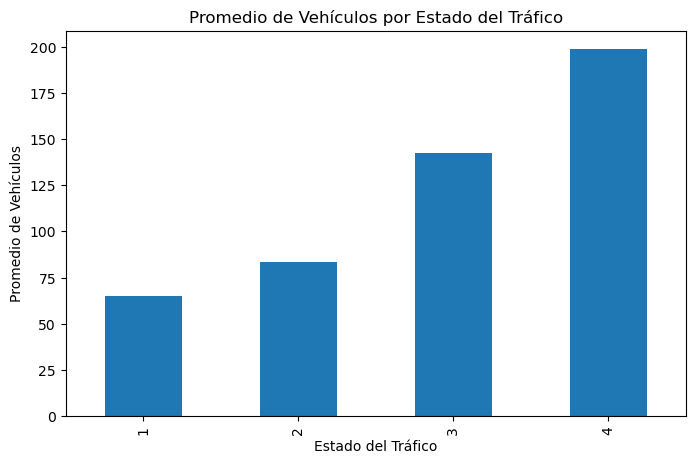

In [222]:
status_analysis = traffic_data.groupby('TrafficStatus')['Total'].mean()

plt.clf()
# Graficar
status_analysis.plot(kind='bar', figsize=(8, 5), title='Promedio de Vehículos por Estado del Tráfico')
plt.xlabel('Estado del Tráfico')
plt.ylabel('Promedio de Vehículos')
plt.show()

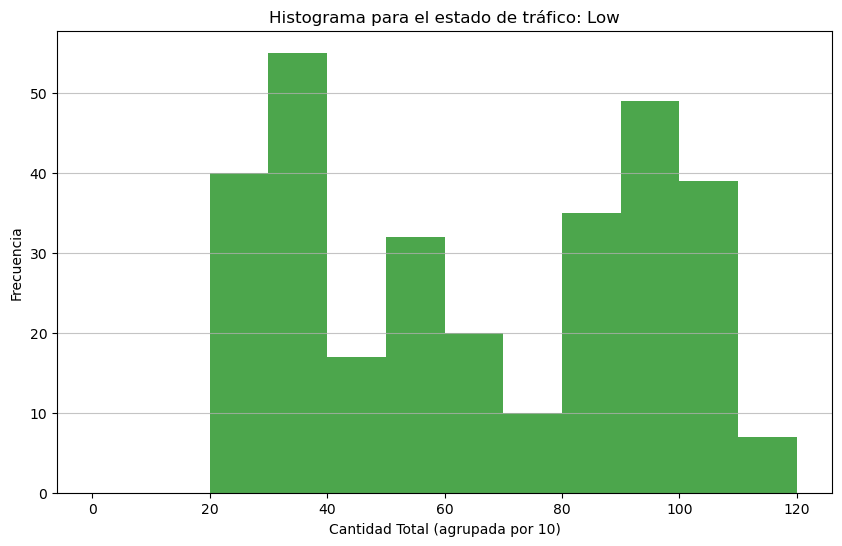

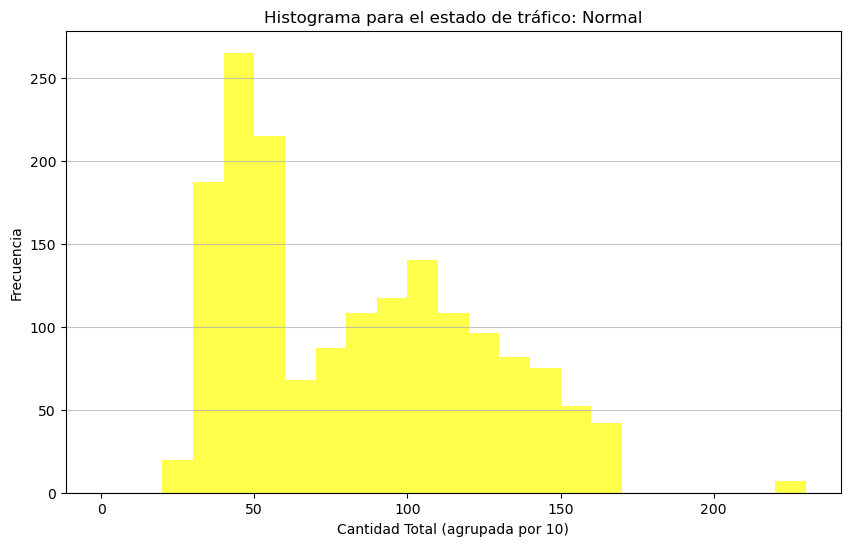

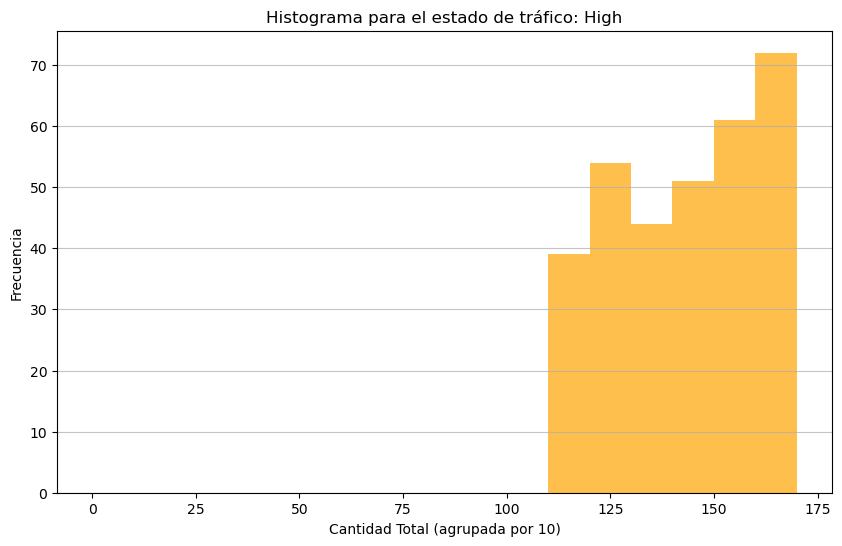

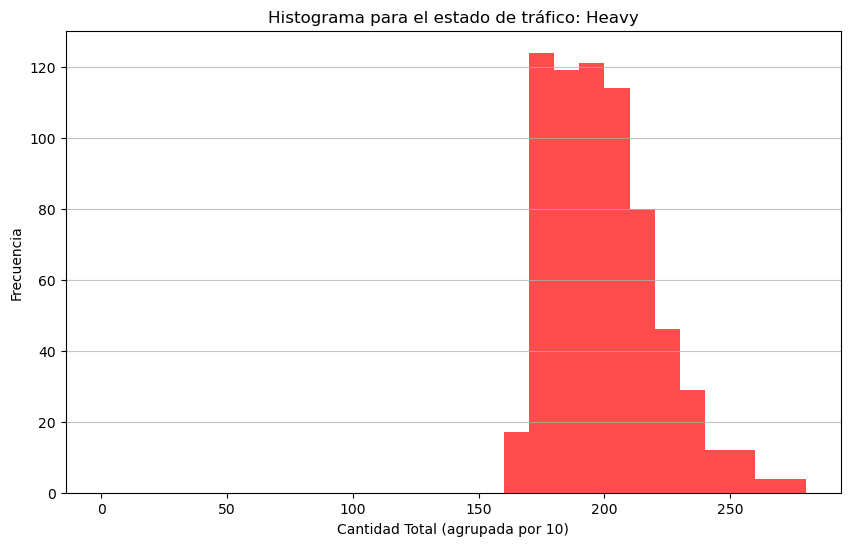

In [223]:
# Crear histogramas para cada estado de tráfico
for status, status_name in reverse_traffic_situation_mapping.items():
    plt.figure(figsize=(10, 6))
    subset = traffic_data[traffic_data['TrafficStatus'] == status]
    plt.hist(subset['Total'], bins=range(0, subset['Total'].max() + 10, 10), color=traffic_situation_colors[status_name], alpha=0.7)
    plt.title(f'Histograma para el estado de tráfico: {status_name.capitalize()}')
    plt.xlabel('Cantidad Total (agrupada por 10)')
    plt.ylabel('Frecuencia')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

### ¿Qué podemos ver en estos histogramas?
Claramente hay una relación entre la cantidad de vehículos y el estado, aunque no es lineal. Hay veces que un tráfico *low* tiene una cantidad de vehículos que también se ve en *normal* o *high*. Esto puede representar un problema cuando tengamos que responder a nuestra pregunta complementaria (recomendar o evitar la autopista).

In [224]:
traffic_avg_dict = status_analysis.to_dict()
print(traffic_avg_dict)

{1: 64.99342105263158, 2: 83.1713600958658, 3: 142.4330218068536, 4: 198.85923753665688}


In [225]:

def add_threshold_lines(mapping, ax=None, colors=None):
    """
    Agrega líneas horizontales de umbral a un gráfico basado en un mapeo de niveles de tráfico.
    
    Parameters:
    - mapping (dict): Diccionario con los niveles de tráfico y sus valores.
    - ax (matplotlib.axes.Axes, optional): Ejes del gráfico al que se agregarán las líneas.
    - colors (dict, optional): Diccionario con colores para cada nivel de tráfico.
    """
    # Ordenar los niveles de tráfico por sus valores
    sorted_mapping = sorted(mapping.items(), key=lambda x: x[1])
    
    # Calcular los puntos de salto (thresholds)
    thresholds = [value for _, value in sorted_mapping]
    labels = [ reverse_traffic_situation_mapping[key] for key, _ in sorted_mapping]

    # Si no se pasa un eje, usar el eje actual
    if ax is None:
        ax = plt.gca()
    
    # Agregar líneas horizontales en los puntos de salto
    for i, threshold in enumerate(thresholds): 
        color = colors[labels[i]] if colors and labels[i] in colors else 'gray'
        ax.axhline(y=threshold, color=color, linestyle='--', alpha=0.7, label=f'{labels[i]} Threshold')
    
    # Agregar leyenda
    ax.legend()

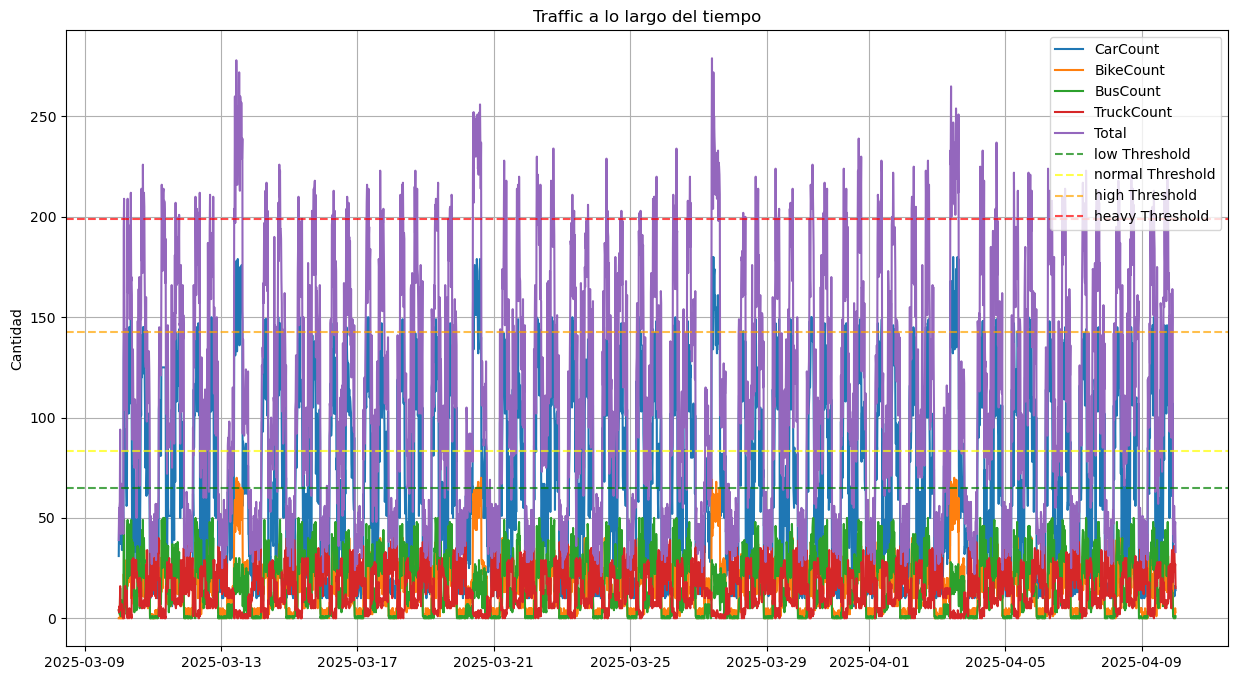

In [226]:
# Crear el gráfico
plt.figure(figsize=(15, 8))
plt.plot(traffic_data['Datetime'], traffic_data['CarCount'], label='CarCount')
plt.plot(traffic_data['Datetime'], traffic_data['BikeCount'], label='BikeCount')
plt.plot(traffic_data['Datetime'], traffic_data['BusCount'], label='BusCount')
plt.plot(traffic_data['Datetime'], traffic_data['TruckCount'], label='TruckCount')
plt.plot(traffic_data['Datetime'], traffic_data['Total'], label='Total')

# Agregar líneas de threshold con colores
add_threshold_lines(traffic_avg_dict, colors=traffic_situation_colors)


# Configurar etiquetas y título
plt.xlabel('')
plt.ylabel('Cantidad')
plt.title('Traffic a lo largo del tiempo')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

Vemos que es ilegible, y esto se debe a que hay 1 mes de dominio y a su vez se divide cada 15 minutos. Vamos a analizar ahora 1 semana, agrupados por hora y divididos por tipo de vehículo.

### Resample
El objetivo del reesample no es solo de visualización, es evitar también un overfitting de los datos. Como contrapartida, puede generarnos luego problemas, una vez más en la pregunta adicional, veremos luego como nos impacta esto.

In [227]:
# Función para calcular la moda
def most_frequent(series):
    return series.mode()[0]  # Devuelve el valor más frecuente

In [228]:
# Agrupar por hora y sumar las columnas restantes
traffic_data_hourly = traffic_data.resample('h', on='Datetime').agg({
    'CarCount': 'sum',
    'BikeCount': 'sum',
    'BusCount': 'sum',
    'TruckCount': 'sum',
    'Total': 'sum',
    'TrafficStatus': most_frequent
})

#traffic_data_hourly['TrafficStatus'] = traffic_data_hourly['TrafficStatus'].round().astype(int)
#traffic_data_hourly['TrafficStatus'] = traffic_data_hourly['TrafficStatus'].apply(lambda x: np.floor(x) if x - np.floor(x) < 0.8 else np.ceil(x)).astype(int)

# Mostrar las primeras filas del nuevo dataset
traffic_data_hourly.head()

#traffic_data_hourly.drop(columns=['Traffic Situation'], inplace=True)

/opt/anaconda3/envs/Fabricio/lib/python3.10/site-packages/pandas/core/groupby/grouper.py:381: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  ax = Index(obj[key], name=key)


CarCount  BikeCount  BusCount  TruckCount  Total  \
Datetime                                                                
2025-03-10 00:00:00       177          0        12          18    207   
2025-03-10 01:00:00       180         10        25          29    244   
2025-03-10 02:00:00       175          0        15          18    208   
2025-03-10 03:00:00       357         38        98           5    498   
2025-03-10 04:00:00       337         90        44          51    522   

                     TrafficStatus  
Datetime                            
2025-03-10 00:00:00              1  
2025-03-10 01:00:00              1  
2025-03-10 02:00:00              1  
2025-03-10 03:00:00              1  
2025-03-10 04:00:00              2

In [229]:
variables_of_interest = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total']
apply_threashold_list = [False, False, False, False, True]
# ¿Por qué solo se aplica a la variable Total? 
# Esto es porque nuestro análisis se basa en el total de vehículos, y no en cada tipo de vehículo por separado.
# Suponemos que, como en la realidad, no existen carriles 100% exclusivos para cada tipo de vehículo.
# Entonces la congestión no la determina un solo tipo de vehículo, sino la suma de todos ellos.

variables_of_interest_friendly_name = ['Cantidad de Autos', 'Cantidad de Bicis', 'Cantidad de Micros', 'Cantidad de Camiones ', 'Total']
variables_of_interest_colors = ['#FF5733', '#33FF57', '#3357FF', '#FF33A1', '#FFA533']

In [230]:
  
start_date = traffic_data['Datetime'].min()
end_date = start_date + datetime.timedelta(weeks=1)

In [231]:
print(f'Fechas de análisis: {start_date} - {end_date}')

Fechas de análisis: 2025-03-10 00:00:00 - 2025-03-17 00:00:00


In [232]:
status_analysis_by_vehicle_dict = {}

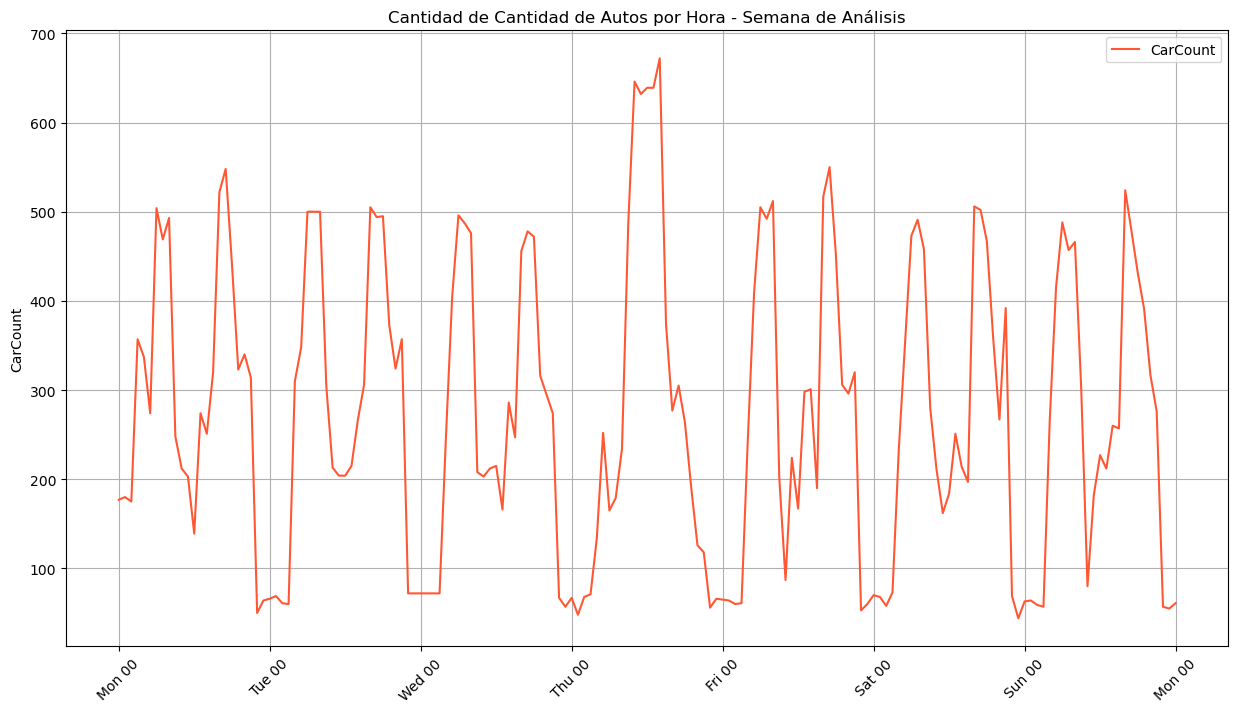

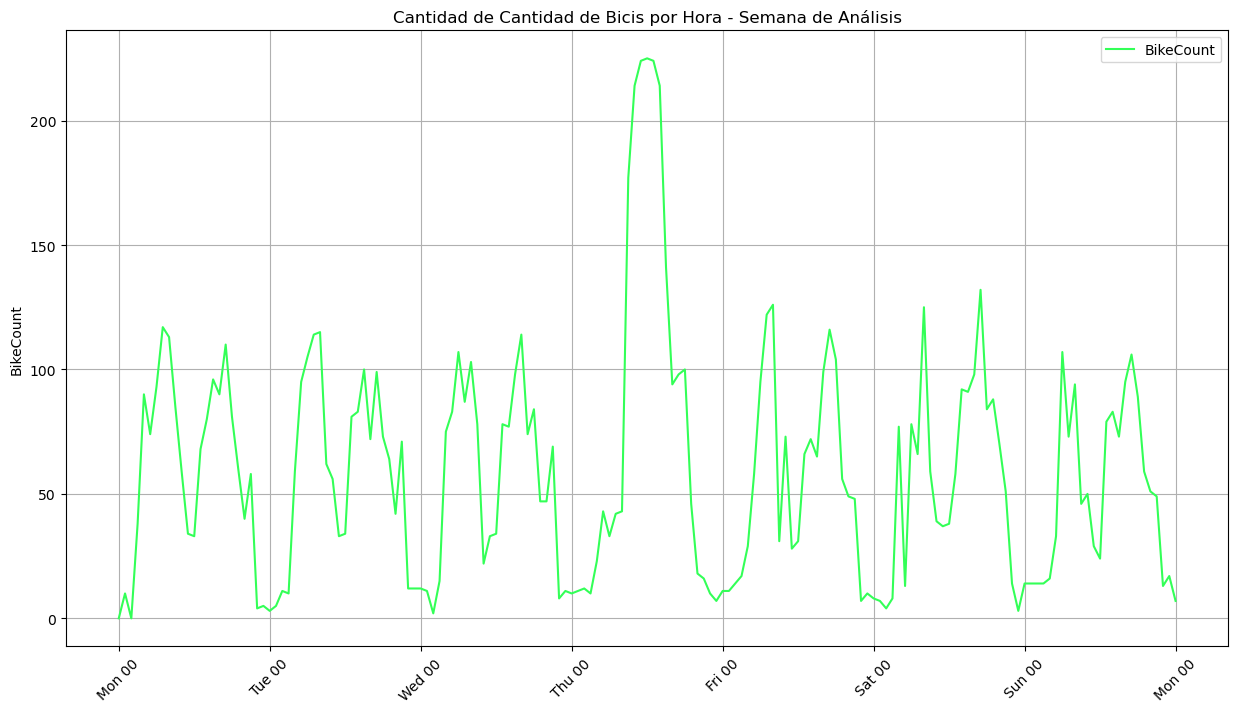

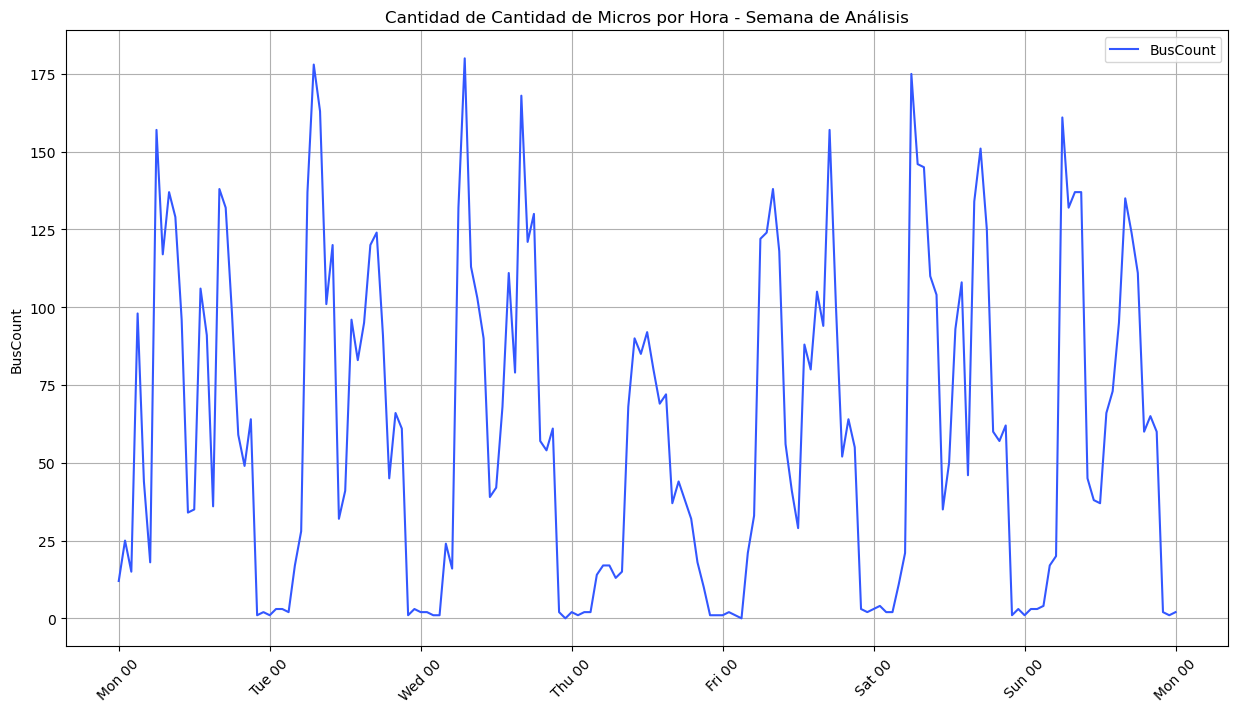

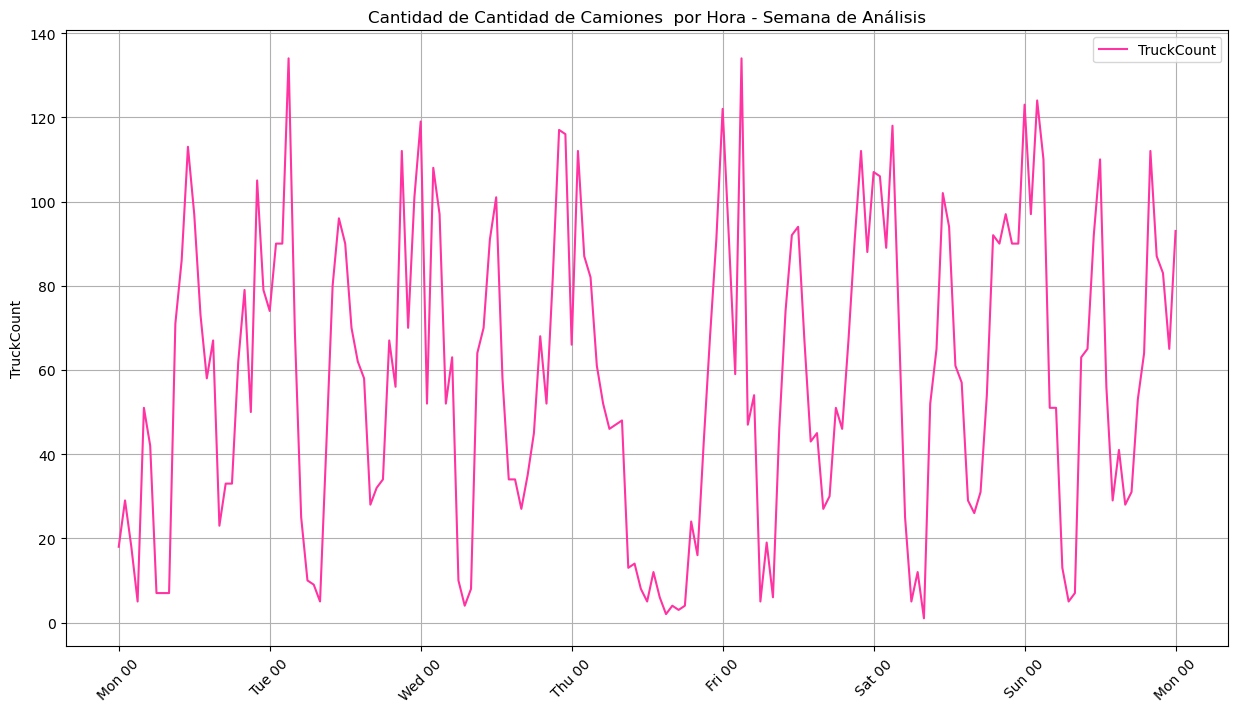

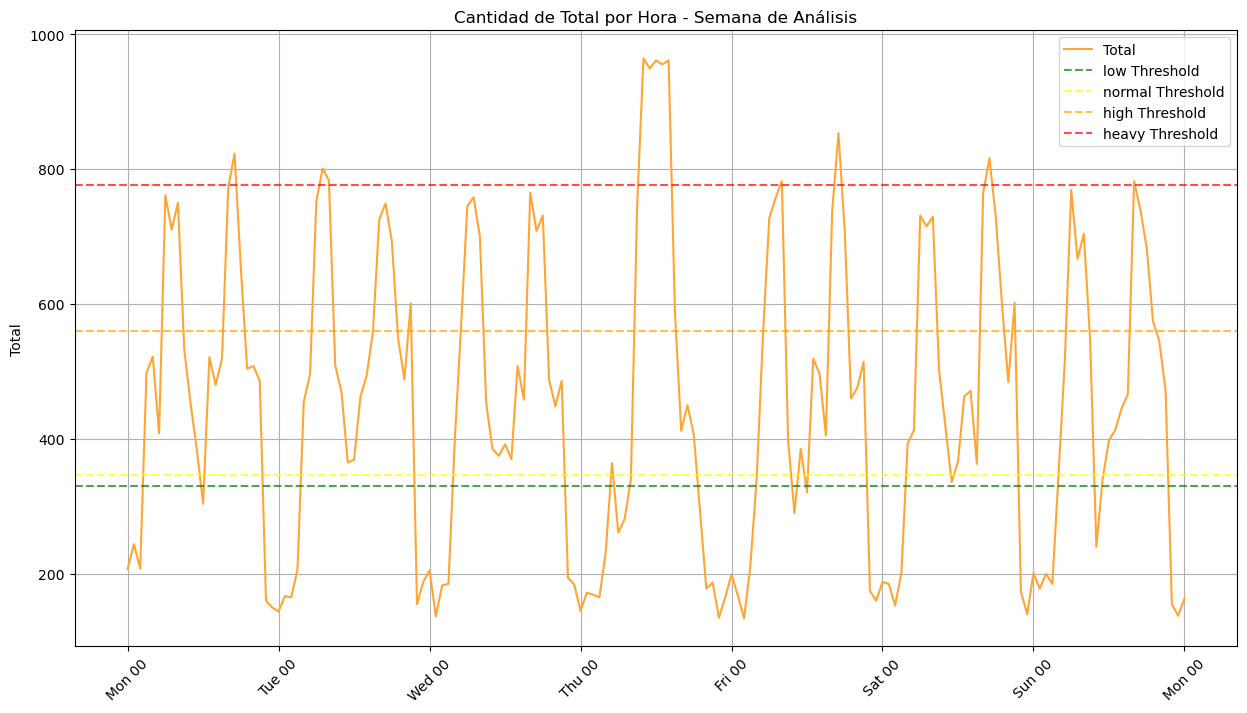

In [233]:
for var, var_friendly_name, color, apply_threashold in zip(variables_of_interest, variables_of_interest_friendly_name,variables_of_interest_colors,apply_threashold_list):
    weekly_data = traffic_data_hourly[start_date:end_date]

    status_analysis_by_vehicle = weekly_data.groupby('TrafficStatus')[variables_of_interest].mean()

    
    traffic_avg_dict_vehicle = status_analysis_by_vehicle[var].to_dict()

    status_analysis_by_vehicle_dict[var] = traffic_avg_dict_vehicle

    # Crear el gráfico
    plt.figure(figsize=(15, 8))
    plt.xticks(weekly_data.index[::24], [f"{d.strftime('%a')} {d.strftime('%H')}" for d in weekly_data.index[::24]], rotation=45)
    plt.plot(weekly_data.index, weekly_data[var], label=var, color=color)

    # Configurar etiquetas y título
    plt.xlabel('')
    plt.ylabel(var)
    plt.title(f'Cantidad de {var_friendly_name} por Hora - Semana de Análisis')
    plt.legend()
    plt.grid(True)

    if (apply_threashold):
        add_threshold_lines(traffic_avg_dict_vehicle, colors=traffic_situation_colors)

    # Mostrar el gráfico
    plt.show()

Podemos ya ver un gráfico más limpio, por hora (la etiqueta lo muestra cada 6 horas para una mejor legibilidad). También, a simple vista, podemos encontrar patrones que se repiten por tipo de vehículo, durante los días de la semana y durantes los horarios del día. Vamos a seguir estudiando el dataset, realizando modelos para poder ver si confirmamos esta tendencia, y si podemos contestar a nuestra pregunta inicial.


## Variable de estudio
La pregunta que nos planteamos busca predecir el tráfico vehicular total para identificar posibles situaciones de congestión y, a partir de ello, tomar medidas para evitarlas. Por este motivo, enfocamos el análisis en la cantidad total de vehículos en circulación, sin diferenciar inicialmente entre los distintos tipos (autos, bicicletas, colectivos o camiones). Aunque cada categoría podría aportar información específica, optamos por una perspectiva global que permita modelar el comportamiento general del flujo vehicular, ya que es este el principal determinante de la congestión.

### Análisis de estacionaridad

Para el análisis de estacionaridad utilizaremos el test de Dickey-Fuller. Este test estadístico permite evaluar si una serie temporal es estacionaria, es decir, si sus propiedades estadísticas como la media y la varianza se mantienen constantes a lo largo del tiempo. El test parte de la hipótesis nula de que la serie no es estacionaria (tiene una raíz unitaria). Si el valor p del test es menor a 0.05, se rechaza la hipótesis nula y se concluye que la serie es estacionaria. Esto es clave para aplicar modelos de predicción como AR o ARIMA, ya que estos requieren que la serie sea estacionaria para generar resultados confiables.

In [234]:
sts.adfuller(traffic_data_hourly['Total'])

(-14.70634773386883,
 2.893340056524601e-27,
 20,
 723,
 {'1%': -3.4394269973845657,
  '5%': -2.8655458544300387,
  '10%': -2.568903174551249},
 8801.784926461152)

La serie temporal analizada puede considerarse estacionaria, ya que el valor p obtenido esta muy por debaja de 0.05 (2.89e-27). Además, la estadística ADF (-14.71) es menor que todos los valores críticos establecidos para los niveles del 1%, 5% y 10%.

### Análisis de correlograma 

El análisis de la función de autocorrelación parcial (PACF) es una evaluación estadística que mide la correlación directa entre una observación de una serie temporal y sus valores en retrasos anteriores, una vez que se ha eliminado el efecto de las correlaciones transmitidas por los retrasos intermedios. Con este análisis se puede identificar el orden p de un modelo autorregresivo, ya que se busca el último retraso significativo antes de que los valores de la PACF se corten bruscamente y caigan dentro del intervalo de confianza (dejando de ser estadísticamente distintos de cero).

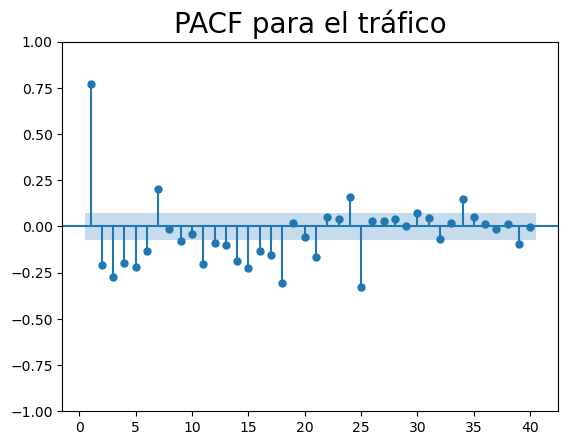

In [235]:
sgt.plot_pacf(traffic_data_hourly['Total'], zero = False, lags = 40)
plt.title("PACF para el tráfico", size = 20)
plt.show()

Del grafico se observas que las barras correspondientes a los primeros 6 retrasos se extienden por fuera del intervalo de confianza. Esto indica que existe una correlación directa y estadísticamente significativa entre la observación actual $ yt $ y cada una de sus observaciones pasadas hasta 6 períodos atrás.

# Modelado

## AR

El modelo AR (Auto Regressive) es un enfoque estadístico utilizado para predecir valores futuros de una serie temporal basándose en sus propios valores pasados. Este modelo se denota como AR(p), donde **p** representa el número de valores anteriores utilizados para realizar la predicción. La ecuación general del modelo AR es:

$$
y_t = \phi_1 y_{t-1} + \phi_2 y_{t-2} + \dots + \phi_p y_{t-p} + \epsilon_t
$$

Donde:

- $y_t$ es el valor actual de la serie temporal,
- $\phi_1, \phi_2, \dots, \phi_p$ son los parámetros del modelo que determinan la influencia de los valores pasados,
- $\epsilon_t$ es el término de error aleatorio, normalmente distribuido con media cero y varianza constante.

Este modelo es útil cuando se observa una relación significativa entre los valores pasados y el valor actual de la serie temporal, como en el caso del tráfico vehicular.   
 

### Modelo AR(1)

In [236]:
# Vamos ajustar nuestras variables de rango al sample
start_date = traffic_data_hourly.index.min()
end_date = start_date + datetime.timedelta(weeks=1)
print(f'Fechas de análisis: {start_date} - {end_date}')

Fechas de análisis: 2025-03-10 00:00:00 - 2025-03-17 00:00:00


In [237]:
traffic_data_hourly_model_ar_1 = ARIMA(traffic_data_hourly['Total'], order=(1,0,0))

In [238]:
traffic_data_hourly_results_ar_1 = traffic_data_hourly_model_ar_1.fit()

In [239]:
traffic_data_hourly_results_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Total   No. Observations:                  744
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -4744.743
Date:                Wed, 23 Apr 2025   AIC                           9495.486
Time:                        20:28:11   BIC                           9509.322
Sample:                    03-10-2025   HQIC                          9500.819
                         - 04-09-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        456.8736     24.121     18.941      0.000     409.598     504.150
ar.L1          0.7738      0.033     23.697      0.000       0.710       0.838
sigma2      2.024e+04    980.999     20.629      0.000    1.83e+04    2.22e+04
===================================================================================
Ljung-Box (L1) (Q):                  19.15   Jarque-Bera (JB):                31.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                             0.22
Prob(H) (two-sided):                  0.69   Kurtosis:                         3.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

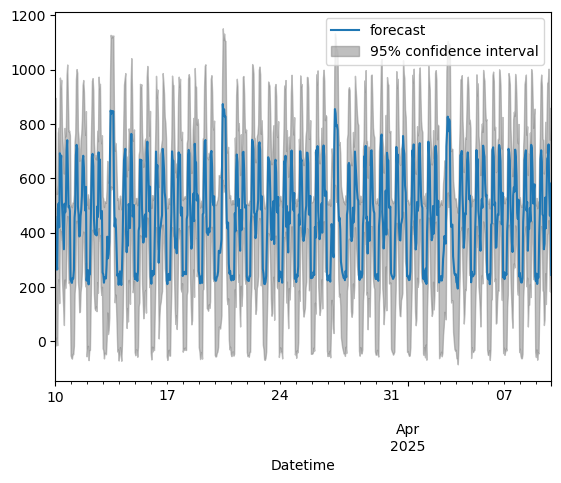

In [240]:
plot_predict(traffic_data_hourly_results_ar_1)

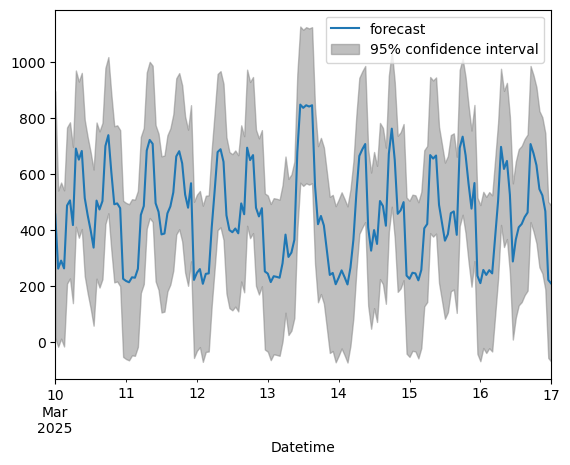

In [241]:
plt.clf()
plot_predict(traffic_data_hourly_results_ar_1, start=start_date, end=end_date)


### Modelo AR(2)

In [242]:
traffic_data_hourly_model_ar_2 = ARIMA(traffic_data_hourly['Total'], order=(2,0,0))

In [243]:
traffic_data_hourly_results_ar_2 = traffic_data_hourly_model_ar_2.fit()

In [244]:
traffic_data_hourly_results_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Total   No. Observations:                  744
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -4728.403
Date:                Wed, 23 Apr 2025   AIC                           9464.805
Time:                        20:28:11   BIC                           9483.254
Sample:                    03-10-2025   HQIC                          9471.917
                         - 04-09-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        456.8736     19.365     23.593      0.000     418.920     494.828
ar.L1          0.9340      0.057     16.445      0.000       0.823       1.045
ar.L2         -0.2074      0.053     -3.917      0.000      -0.311      -0.104
sigma2      1.939e+04    896.669     21.625      0.000    1.76e+04    2.11e+04
===================================================================================
Ljung-Box (L1) (Q):                   2.47   Jarque-Bera (JB):                49.57
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                             0.20
Prob(H) (two-sided):                  0.58   Kurtosis:                         4.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

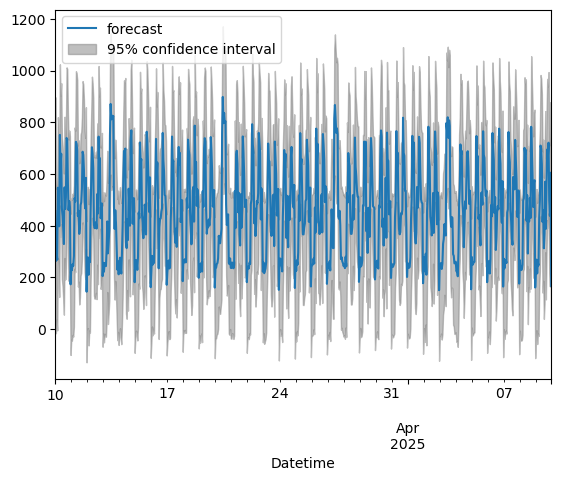

In [245]:
plot_predict(traffic_data_hourly_results_ar_2)

<Figure size 640x480 with 0 Axes>

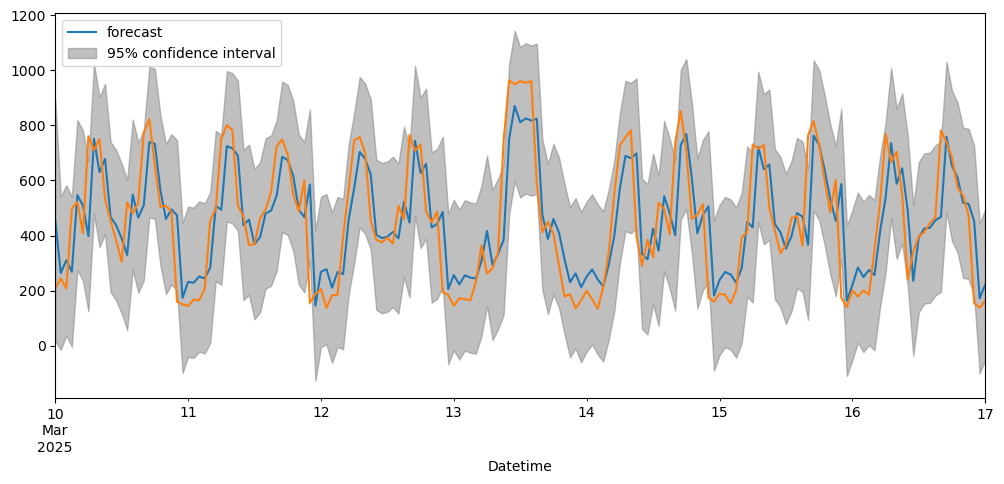

In [310]:
plt.clf()
plot_predict(traffic_data_hourly_results_ar_2, start=start_date, end=end_date)
weekly_data['Total'].plot(figsize=(12,5))
plt.show()

### Modelo AR(5)

In [247]:
traffic_data_hourly_model_ar_5 = ARIMA(traffic_data_hourly['Total'], order=(5,0,0))

In [248]:
traffic_data_hourly_results_ar_5 = traffic_data_hourly_model_ar_5.fit()

In [249]:
traffic_data_hourly_results_ar_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Total   No. Observations:                  744
Model:                 ARIMA(5, 0, 0)   Log Likelihood               -4665.311
Date:                Wed, 23 Apr 2025   AIC                           9344.622
Time:                        20:28:11   BIC                           9376.907
Sample:                    03-10-2025   HQIC                          9357.067
                         - 04-09-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        456.8736      9.597     47.607      0.000     438.064     475.683
ar.L1          0.7787      0.047     16.638      0.000       0.687       0.870
ar.L2          0.0399      0.063      0.633      0.527      -0.084       0.163
ar.L3         -0.0945      0.055     -1.710      0.087      -0.203       0.014
ar.L4         -0.0115      0.056     -0.205      0.837      -0.122       0.099
ar.L5         -0.2224      0.044     -5.077      0.000      -0.308      -0.137
sigma2      1.636e+04    914.417     17.886      0.000    1.46e+04    1.81e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):                14.31
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             0.28
Prob(H) (two-sided):                  0.96   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

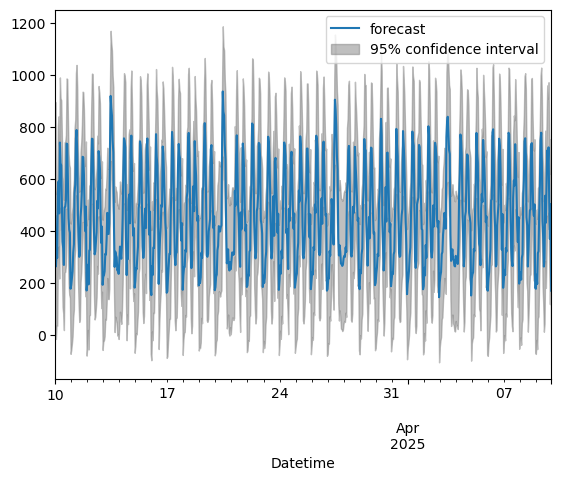

In [250]:
plot_predict(traffic_data_hourly_results_ar_5)

<Figure size 640x480 with 0 Axes>

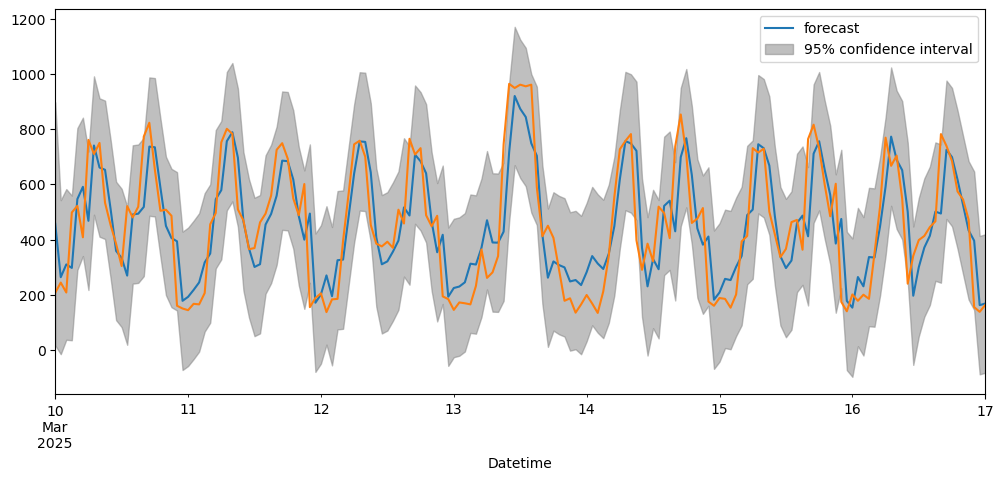

In [251]:
plt.clf()
plot_predict(traffic_data_hourly_results_ar_5, start=start_date, end=end_date)
weekly_data['Total'].plot(figsize=(12,5))
plt.show()

A partir del análisis del correlograma, el rezago 6 aparece como un posible candidato para definir el orden del modelo AR. Sin embargo, al ajustar un modelo AR(5), se observa que varios de sus coeficientes no resultan estadísticamente significativos (p > 0.05), lo que sugiere que agregar un sexto rezago no aportaría mejoras sustanciales. Por lo tanto, podemos concluir que un modelo AR(6) no ofrece ventajas claras frente al AR(5) y podría implicar una complejidad innecesaria sin mejorar el desempeño del modelo.

### Comparar modelos

In [252]:
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF)
    return p

In [253]:
LLR_test(traffic_data_hourly_model_ar_1, traffic_data_hourly_model_ar_2,DF=1)

1.0864419820869832e-08

#### Resultado
Este es el valor (p), que es extremadamente pequeño (mucho menor que 0.05). Esto indica que el modelo más complejo (traffic_data_hourly_model_ar_2) mejora  el ajuste en comparación con el modelo más simple (traffic_data_hourly_model_ar_1).


## ARMA

El modelo **ARMA** (*Auto Regressive Moving Average*) combina dos componentes: un modelo autorregresivo (AR) y un modelo de media móvil (MA). Es útil para modelar series temporales estacionarias que presentan correlaciones tanto con valores pasados como con errores pasados. Se denota como **ARMA(p, q)**, donde **p** es el orden del componente autorregresivo y **q** el orden del componente de media móvil. La ecuación general es:

$$
y_t = \phi_1 y_{t-1} + \dots + \phi_p y_{t-p} + \theta_1 \epsilon_{t-1} + \dots + \theta_q \epsilon_{t-q} + \epsilon_t
$$

Donde:

- $y_t$ es el valor actual de la serie temporal,  
- $\phi_1, \dots, \phi_p$ son los coeficientes del componente AR,  
- $\theta_1, \dots, \theta_q$ son los coeficientes del componente MA,  
- $\epsilon_t$ es el término de error aleatorio, con media cero y varianza constante.

El modelo **ARMA** permite capturar tanto la dependencia directa entre observaciones pasadas como los patrones en los errores

### Modelo ARMA(1,1)

In [254]:
traffic_data_hourly_model_ar_1_ma_1 = ARIMA(traffic_data_hourly['Total'], order=(1,0,1))

In [255]:
traffic_data_hourly_results_ar_1_ma_1 = traffic_data_hourly_model_ar_1_ma_1.fit()

In [256]:
traffic_data_hourly_results_ar_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Total   No. Observations:                  744
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -4735.057
Date:                Wed, 23 Apr 2025   AIC                           9478.115
Time:                        20:28:12   BIC                           9496.563
Sample:                    03-10-2025   HQIC                          9485.226
                         - 04-09-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        456.8736     21.887     20.874      0.000     413.976     499.772
ar.L1          0.7126      0.045     15.868      0.000       0.625       0.801
ma.L1          0.1628      0.065      2.495      0.013       0.035       0.291
sigma2       1.99e+04    952.448     20.891      0.000     1.8e+04    2.18e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):                44.11
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                             0.21
Prob(H) (two-sided):                  0.61   Kurtosis:                         4.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Figure size 640x480 with 0 Axes>

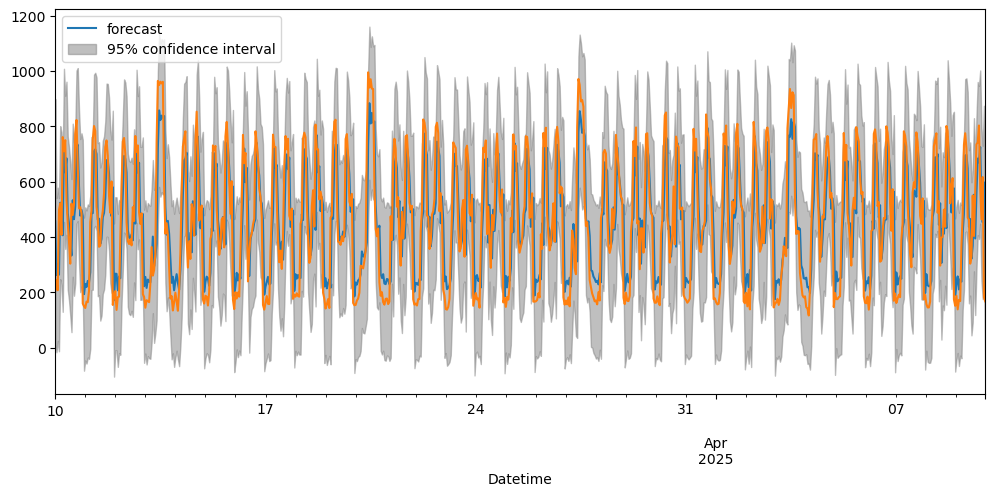

In [257]:
plt.clf()
plot_predict(traffic_data_hourly_results_ar_1_ma_1)
traffic_data_hourly['Total'].plot(figsize=(12,5))
plt.show()

<Figure size 640x480 with 0 Axes>

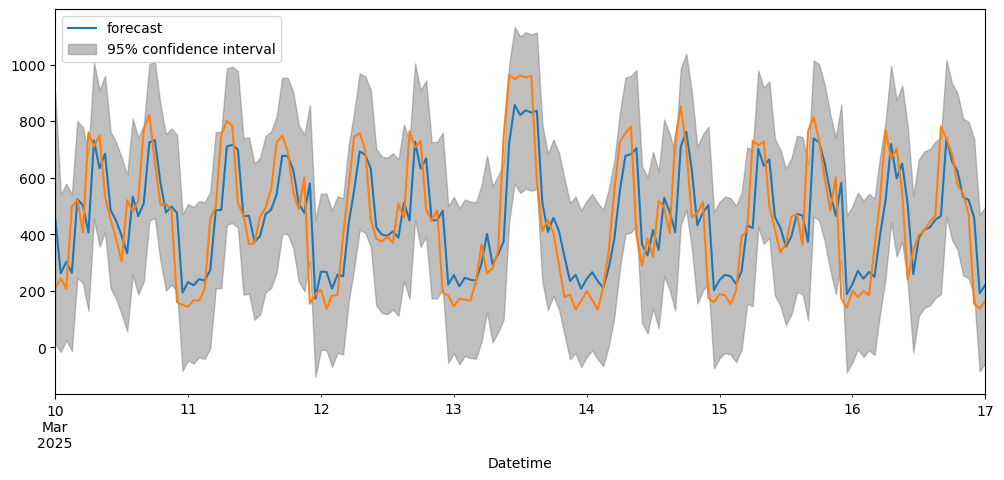

In [258]:
plt.clf()
plot_predict(traffic_data_hourly_results_ar_1_ma_1, start=start_date, end=end_date)
weekly_data['Total'].plot(figsize=(12,5))
plt.show()

### Modelo ARMA(1,2)

In [259]:
traffic_data_hourly_model_ar_1_ma_2 = ARIMA(traffic_data_hourly['Total'], order=(1,0,2))

In [260]:
traffic_data_hourly_results_ar_1_ma_2 = traffic_data_hourly_model_ar_1_ma_2.fit()

In [261]:
traffic_data_hourly_results_ar_1_ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Total   No. Observations:                  744
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -4720.043
Date:                Wed, 23 Apr 2025   AIC                           9450.085
Time:                        20:28:12   BIC                           9473.145
Sample:                    03-10-2025   HQIC                          9458.974
                         - 04-09-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        456.8169     20.266     22.541      0.000     417.095     496.538
ar.L1          0.6027      0.057     10.524      0.000       0.490       0.715
ma.L1          0.2799      0.068      4.128      0.000       0.147       0.413
ma.L2          0.2209      0.058      3.814      0.000       0.107       0.334
sigma2      1.894e+04    895.746     21.143      0.000    1.72e+04    2.07e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                60.92
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                             0.15
Prob(H) (two-sided):                  0.72   Kurtosis:                         4.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Figure size 640x480 with 0 Axes>

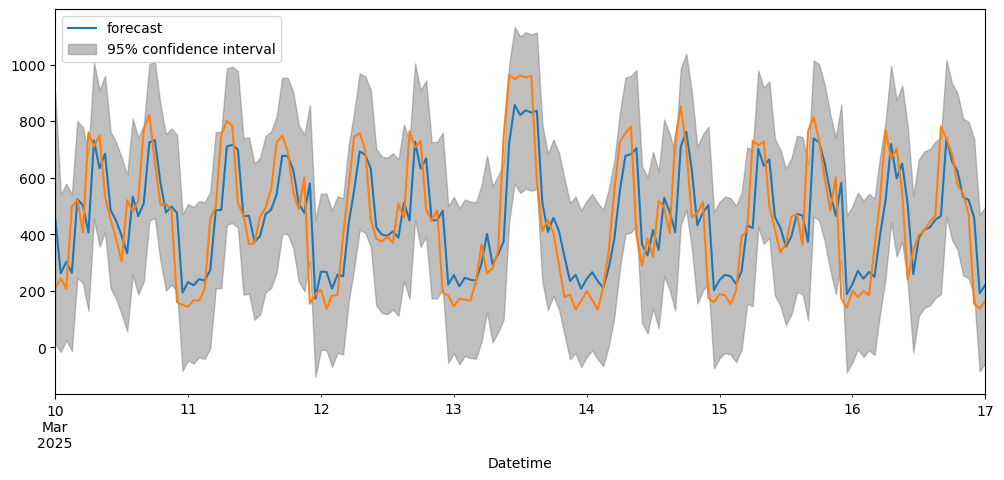

In [262]:
plt.clf()
plot_predict(traffic_data_hourly_results_ar_1_ma_1, start=start_date, end=end_date)
weekly_data['Total'].plot(figsize=(12,5))
plt.show()

### Comparación de modelos
traffic_data_hourly_model_ar_1_ma_2 es mejor que traffic_data_hourly_model_ar_1_ma_1 porque el valor (p) es muy pequeño, lo que sugiere que el modelo más complejo mejora  el ajuste.


In [263]:
LLR_test(traffic_data_hourly_model_ar_1_ma_1, traffic_data_hourly_model_ar_1_ma_2,DF=1)

4.255693087427475e-08

## Auto ARIMA

El modelo Auto ARIMA es una extensión automatizada del modelo ARIMA que selecciona de manera óptima los parámetros \( p \), \( d \) y \( q \) mediante criterios estadísticos como el AIC (Criterio de Información de Akaike) o el BIC (Criterio de Información Bayesiano). Su principal ventaja es que evita el proceso manual de prueba y error al ajustar un modelo ARIMA, explorando automáticamente diferentes combinaciones de parámetros para encontrar el modelo que mejor se ajusta a los datos.

In [264]:
traffic_data_hourly_auto_model = auto_arima(traffic_data_hourly['Total'])

In [265]:
traffic_data_hourly_auto_model

ARIMA(order=(2, 0, 1), scoring_args={}, suppress_warnings=True)

In [266]:
traffic_data_hourly_auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  744
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -4650.041
Date:                Wed, 23 Apr 2025   AIC                           9310.081
Time:                        20:28:13   BIC                           9333.142
Sample:                    03-10-2025   HQIC                          9318.970
                         - 04-09-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     50.6854      4.192     12.092      0.000      42.470      58.901
ar.L1          1.7276      0.028     61.473      0.000       1.672       1.783
ar.L2         -0.8391      0.028    -29.940      0.000      -0.894      -0.784
ma.L1         -0.9437      0.021    -44.709      0.000      -0.985      -0.902
sigma2      1.499e+04    760.606     19.712      0.000    1.35e+04    1.65e+04
===================================================================================
Ljung-Box (L1) (Q):                   5.63   Jarque-Bera (JB):                16.14
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                             0.19
Prob(H) (two-sided):                  0.76   Kurtosis:                         3.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [267]:
traffic_data_hourly_auto_results = traffic_data_hourly_auto_model.fit(traffic_data_hourly['Total'])

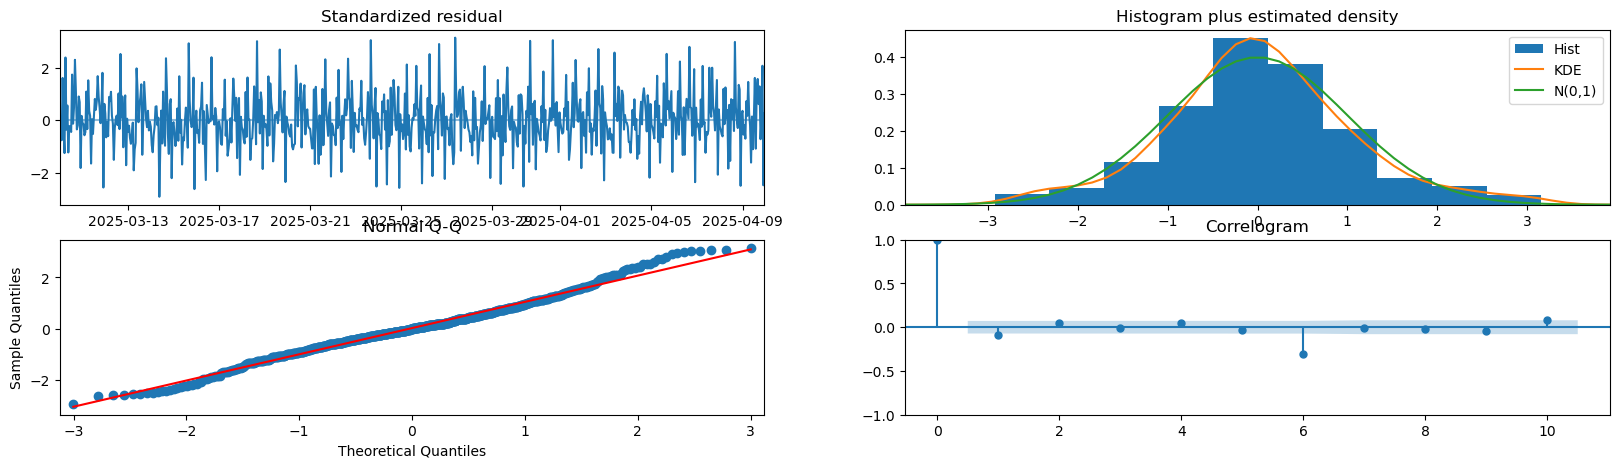

In [268]:
traffic_data_hourly_auto_results.plot_diagnostics(figsize=(20,5))

In [269]:
traffic_data_hourly['AutoModel'] =traffic_data_hourly_auto_results.predict_in_sample(n_periods=len(traffic_data_hourly))

In [270]:
traffic_data_hourly['AutoModel'].plot(figsize=(12,5));

In [271]:
traffic_data_hourly['AutoModel'][start_date:end_date].plot(figsize=(12,5));

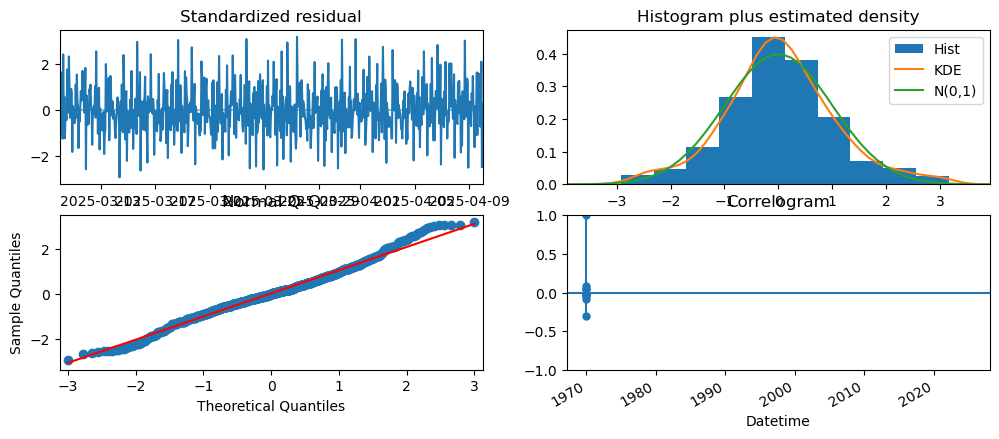

In [272]:
traffic_data_hourly_auto_results.predict_in_sample(n_periods=len(traffic_data_hourly)).plot()
traffic_data_hourly['Total'].plot(figsize=(12,5));
plt.show()

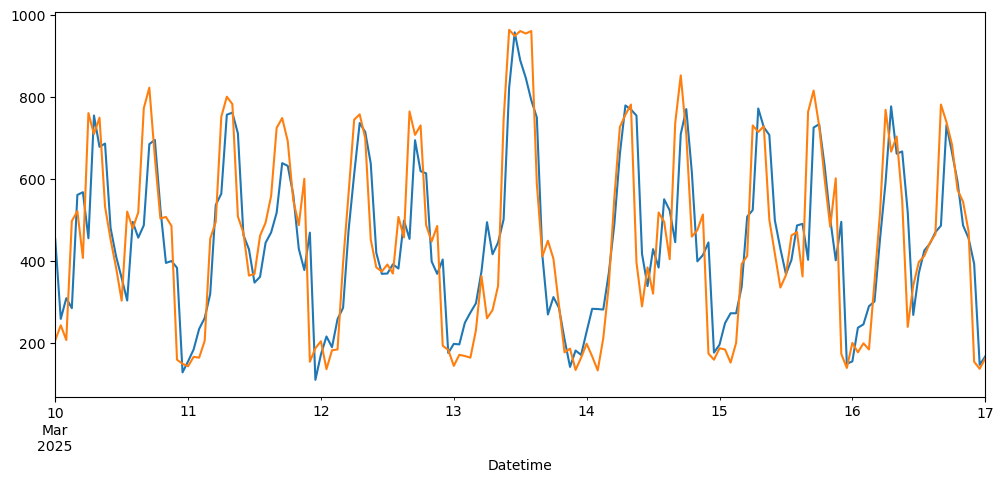

In [273]:
traffic_data_hourly_auto_results.predict_in_sample(start=start_date, end=end_date).plot()
traffic_data_hourly['Total'][start_date:end_date].plot(figsize=(12,5));
plt.show()

Probaremos otra semana


In [274]:
other_start_date = start_date + datetime.timedelta(weeks=1)
other_end_date = other_start_date + datetime.timedelta(weeks=1)

In [275]:
print(f'Fechas de análisis: {other_start_date} - {other_end_date}')

Fechas de análisis: 2025-03-17 00:00:00 - 2025-03-24 00:00:00


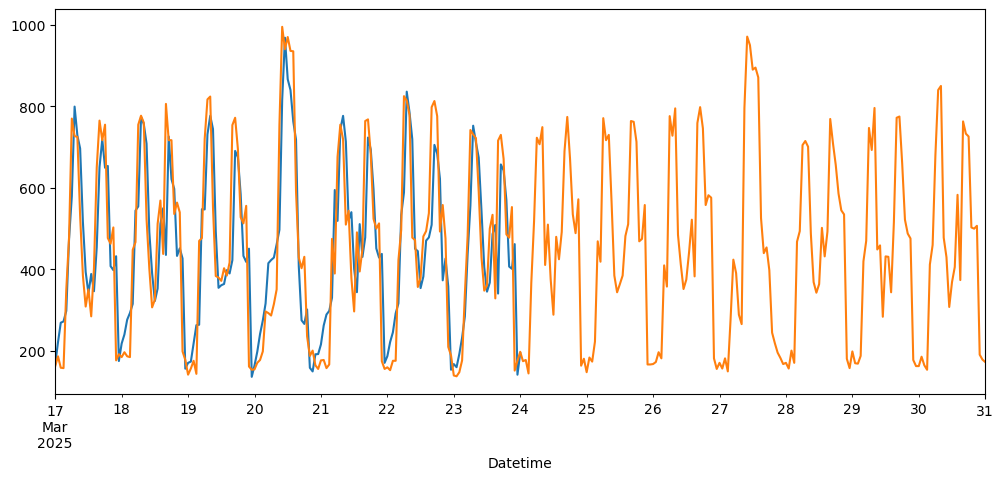

In [276]:
plt.clf()
traffic_data_hourly_auto_results.predict_in_sample(start=other_start_date, end=other_end_date).plot()

forecast_end_date = other_end_date + datetime.timedelta(weeks=1)

traffic_data_hourly['Total'][other_start_date:forecast_end_date].plot(figsize=(12,5))
plt.show()

## Análisis e interpretación de resultados

In [277]:
# Crear un diccionario para almacenar los valores de AIC y BIC
model_metrics = {}

# Guardar los valores de AIC y BIC de los modelos
model_metrics['AR(1)'] = {
    'AIC': traffic_data_hourly_results_ar_1.aic,
    'BIC': traffic_data_hourly_results_ar_1.bic
}

model_metrics['AR(2)'] = {
    'AIC': traffic_data_hourly_results_ar_2.aic,
    'BIC': traffic_data_hourly_results_ar_2.bic
}

model_metrics['AR(5)'] = {
    'AIC': traffic_data_hourly_results_ar_5.aic,
    'BIC': traffic_data_hourly_results_ar_5.bic
}

model_metrics['ARMA(1,1)'] = {
    'AIC': traffic_data_hourly_results_ar_1_ma_1.aic,
    'BIC': traffic_data_hourly_results_ar_1_ma_1.bic
}

model_metrics['ARMA(1,2)'] = {
    'AIC': traffic_data_hourly_results_ar_1_ma_2.aic,
    'BIC': traffic_data_hourly_results_ar_1_ma_2.bic
}
model_metrics['Auto ARIMA'] = {
    'AIC': traffic_data_hourly_auto_results.aic(),
    'BIC': traffic_data_hourly_auto_results.bic()
}

# Convertir el diccionario en un DataFrame para mostrarlo como tabla
model_metrics_df = pd.DataFrame.from_dict(model_metrics, orient='index')
print(model_metrics_df)

                    AIC          BIC
AR(1)       9495.485524  9509.321647
AR(2)       9464.805431  9483.253595
AR(5)       9344.622448  9376.906735
ARMA(1,1)   9478.114571  9496.562735
ARMA(1,2)   9450.085281  9473.145486
Auto ARIMA  9310.081357  9333.141562


In [309]:

# Calcular MSE para cada modelo
mape_results = {}

# AR(1)
mape_results['AR(1)'] = mean_absolute_percentage_error(traffic_data_hourly['Total'], traffic_data_hourly_results_ar_1.fittedvalues)

# AR(2)
mape_results['AR(2)'] = mean_absolute_percentage_error(traffic_data_hourly['Total'], traffic_data_hourly_results_ar_2.fittedvalues)

# AR(5)
mape_results['AR(5)'] = mean_absolute_percentage_error(traffic_data_hourly['Total'], traffic_data_hourly_results_ar_5.fittedvalues)

# ARMA(1,1)
mape_results['ARMA(1,1)'] = mean_absolute_percentage_error(traffic_data_hourly['Total'], traffic_data_hourly_results_ar_1_ma_1.fittedvalues)

# ARMA(1,2)
mape_results['ARMA(1,2)'] = mean_absolute_percentage_error(traffic_data_hourly['Total'], traffic_data_hourly_results_ar_1_ma_2.fittedvalues)

# Auto ARIMA
mape_results['Auto ARIMA'] = mean_absolute_percentage_error(traffic_data_hourly['Total'], traffic_data_hourly_auto_results.predict_in_sample())

# Mostrar resultados
for model, mse in mape_results.items():
    print(f"MAPE for {model}: {mse}")

MAPE for AR(1): 0.3095623706503882
MAPE for AR(2): 0.30365640529902516
MAPE for AR(5): 0.2916169133342926
MAPE for ARMA(1,1): 0.3036682205140807
MAPE for ARMA(1,2): 0.2977791920332622
MAPE for Auto ARIMA: 0.2665846443512027


## Modelo ganador
A pesar de tener valores de AIC y BIC muy parecidos, consideramos que el mejor modelo para predecir la cantidad de vehículos es Auto ARIMA.

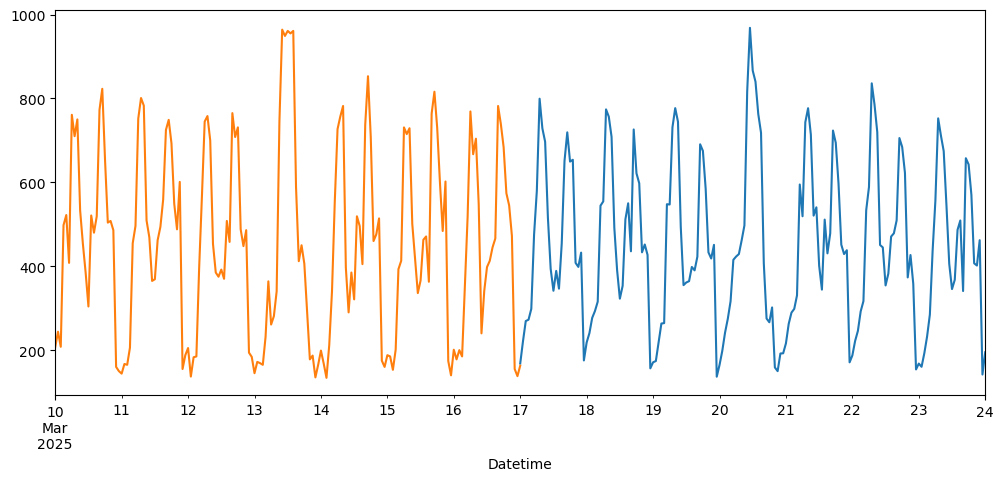

In [279]:
plt.clf()
traffic_data_hourly_auto_results.predict_in_sample(start=other_start_date, end=other_end_date).plot()
traffic_data_hourly['Total'][start_date:end_date].plot(figsize=(12,5));
plt.show()

### Análisis de resultados para contestar a la pregunta secundaria.
Vamos a ver y predecir el estado del tráfico de acuerdo al umbral pre establecido. Recordemos que el umbral se estableció a partir de los datos del dataset y se eligió como estadístico a la media de cada estado. Es decir en promedio, cuántos vehículo hubo en cada estado del tráfico en los datos analizados.

In [280]:
for status_key,ceiling in status_analysis_by_vehicle_dict["Total"].items():
    print(f'{reverse_traffic_situation_mapping[status_key]}: {ceiling}')

low: 330.7857142857143
normal: 346.1290322580645
high: 559.5555555555555
heavy: 776.8205128205128


In [281]:
predicted_total = 359
def GetBestStatus(predicted_total):
    best_status = 1
    for status_key,ceiling in  status_analysis_by_vehicle_dict["Total"].items():

        if predicted_total > ceiling:        
            best_status = status_key
        else:
            break
        
    predicted_status_label = reverse_traffic_situation_mapping[best_status]
    return predicted_status_label
    
predicted_status_label = GetBestStatus(predicted_total)
print(f'{predicted_status_label}')

normal


In [282]:
def predict_traffic_status(input_date):
    # Convertir la fecha de entrada a un objeto datetime
    input_datetime = pd.to_datetime(input_date)

    # Verificar si la fecha está dentro del rango del modelo


    # Predecir el tráfico total para la fecha dada
    predicted_total = traffic_data_hourly_auto_results.predict_in_sample(start=input_datetime, end=input_datetime).iloc[0]

        
    predicted_status_label = GetBestStatus(predicted_total)

    # Obtener el verdadero estado del tráfico si está disponible
    true_status = traffic_data_hourly.loc[input_datetime, 'TrafficStatus'] if input_datetime in traffic_data_hourly.index else None
    true_total = traffic_data_hourly.loc[input_datetime, 'Total'] if input_datetime in traffic_data_hourly.index else 0


    # Si el verdadero estado está disponible, mostrarlo junto con la predicción
    if true_status is not None:
        true_status_label = reverse_traffic_situation_mapping[true_status]
    else:
        true_status_label = "N/A"

    #Predicción vs Verdadero    
    return int(predicted_total), predicted_status_label, true_total, true_status_label

# Crear una lista de ejemplos con diferentes fechas
example_dates = ["2025-03-10 12:00:00", "2025-03-15 18:00:00", "2025-03-20 08:00:00", "2025-04-07 08:00:00", "2025-04-11 08:00:00"]

# Generar predicciones para cada fecha
example_results = []
for date in example_dates:
    predicted_total, predicted_status_label, true_status, true_status_label = predict_traffic_status(date)
    example_results.append({"Fecha": date, "Pred": predicted_total, "Estado (Pred)": predicted_status_label, "True": true_status, "Estado (True)": true_status_label, "Dif": (true_status - predicted_total), "%":((true_status - predicted_total)/(true_status if true_status > 0 else 1)* 100)})


# Imprimir los thresholds para cada estado de tráfico
print("Thresholds por estado de tráfico:")
for status, threshold in status_analysis_by_vehicle_dict['Total'].items():
    print(f"Estado: {reverse_traffic_situation_mapping[status]}, Threshold: {threshold}")

# Mostrar los resultados en una tabla
example_results_df = pd.DataFrame(example_results)
print(example_results_df)

Thresholds por estado de tráfico:
Estado: low, Threshold: 330.7857142857143
Estado: normal, Threshold: 346.1290322580645
Estado: high, Threshold: 559.5555555555555
Estado: heavy, Threshold: 776.8205128205128
                 Fecha  Pred Estado (Pred)  True Estado (True)  Dif  \
0  2025-03-10 12:00:00   359        normal   304        normal  -55   
1  2025-03-15 18:00:00   734          high   730         heavy   -4   
2  2025-03-20 08:00:00   461        normal   351           low -110   
3  2025-04-07 08:00:00   735          high   727        normal   -8   
4  2025-04-11 08:00:00   460        normal     0           N/A -460   

              %  
0    -18.092105  
1     -0.547945  
2    -31.339031  
3     -1.100413  
4 -46000.000000  


In [283]:
true_labels = traffic_data_hourly['TrafficStatus'].map(reverse_traffic_situation_mapping)

# Obtener el rango de fechas del índice de traffic_data_hourly
start_date_test = traffic_data_hourly.index.min()  # Fecha mínima
end_date_test = traffic_data_hourly.index.max()    # Fecha máxima


# Generar predicciones para el rango de fechas
predictions = traffic_data_hourly_auto_results.predict_in_sample(start=start_date_test, end=end_date_test)


predicted_labels = predictions.map(
    lambda x: GetBestStatus(x)
)



### Métricas de este sub problema de clasificación

In [284]:
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.38


In [285]:

precision = precision_score(true_labels, predicted_labels, average='weighted')  # 'weighted' para múltiples clases
print(f'Precision: {precision:.2f}')

Precision: 0.63


In [286]:

recall = recall_score(true_labels, predicted_labels, average='weighted')
print(f'Recall: {recall:.2f}')

Recall: 0.38


In [287]:

f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f'F1 Score: {f1:.2f}')

F1 Score: 0.42


In [288]:
# Crear un diccionario con las métricas
metrics_dict = {
    "Accuracy (TS)": [accuracy],
    "Precision (TS)": [precision],
    "Recall (TS)": [recall],
    "F1 Score (TS)": [f1]
}

# Convertir el diccionario en un DataFrame
metrics_df = pd.DataFrame(metrics_dict)

# Mostrar el DataFrame
print(metrics_df)

   Accuracy (TS)  Precision (TS)  Recall (TS)  F1 Score (TS)
0       0.384409        0.634019     0.384409       0.424566


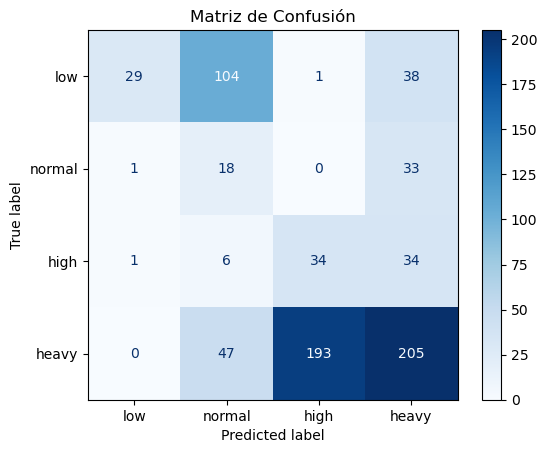

In [289]:
# Crear la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(reverse_traffic_situation_mapping.values()))
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión")
plt.show()


## Alternativa
¿Qué tal si nos preguntamos de forma binaria si nos conviene o no evitar tal horario para utilizar la autopista? Si el tráfico esta bajo o normal, vamos y si está alto o pesado, lo evitamos.

In [290]:
high_threshold = status_analysis_by_vehicle_dict["Total"][3]
print(f'El umbral de alto es: {high_threshold}')

El umbral de alto es: 559.5555555555555


In [291]:
def ShouldUseHighway(predicted_total):
    return predicted_total < high_threshold

In [292]:
true_labels_binary  = traffic_data_hourly['Total'].map(ShouldUseHighway)
pred_labels_binary  = predictions.map(ShouldUseHighway)

In [293]:
accuracy = accuracy_score(true_labels_binary, pred_labels_binary)
print(f"Accuracy: {accuracy:.2f}")

precision = precision_score(true_labels_binary, pred_labels_binary, average='weighted')  # 'weighted' para múltiples clases
print(f'Precision: {precision:.2f}')


recall = recall_score(true_labels_binary, pred_labels_binary, average='weighted')
print(f'Recall: {recall:.2f}')

f1 = f1_score(true_labels_binary, pred_labels_binary, average='weighted')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.85
Precision: 0.85
Recall: 0.85
F1 Score: 0.85


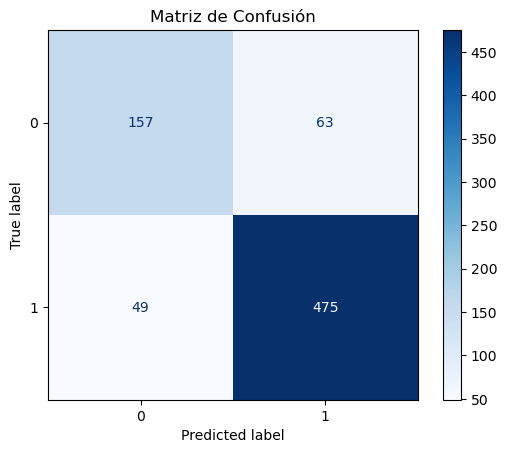

In [294]:
# Crear la matriz de confusión
conf_matrix = confusion_matrix(true_labels_binary, pred_labels_binary)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión")
plt.show()

# Respuesta a la pregunta de investigación
Es posible predecir la cantidad de vehículos en la autopista  en un detarminado día y horario a partir de la serie generada con los datos. 

## Respuesta a la pregunta secundaria
Establecimos un umbral para cada estado. Si queremos conocer exactamente el estado para una fecha hora, no tendremos una excelente respuesta mas si nos proponemos de forma binaria preguntarnos si nos conviene utilizar la autopista, la respuesta mejora sustancialemnte, logrando un accuracy del 80%.


# Problemas, inconvientes, desafíos que tuvimos que atravesar durante el desarrollo del trabajo práctico
1. Como suele ocurrir con desarrollos en que se utilizan diferentes librerías de python, tuvimos problemas de compatibilidad. Es por eso que decidimos crear un entorno conda *AST* para aislar el entorno de trabajo y contar con librerías compatibles entre sí.

2. En cuanto a los datos, el principal desafío fue encontrar un agrupamiento justo, que nos evite un overfitting y a su vez que no generalize tanto. Es por eso que terminamos optando por agrupar los datos cada 1 hora. Como se complicaba la visualización, en los gráficos adicionalmente imprimimos una versión acotada de una semana.

# Conclusiones
1. No siempre el modelo más complejo es el mejor.El Auto ARIMA obtuvo el mejor AIC.

2. Como vemos en los histogramas de cantidad de vehículos por estado de tráfico, no siempre menos cantidad significa mayor fluidez.

3. No parece haber una relación clara entre la cantidad de vehículos y los diferentes estados del tráfico que podamos detectar con un análisis de serie de tiempo de la cantidad y mapeándola con los umbrales establecidos. En cambio, si hacemos un corte binario tenemos buenos resultados, recordemos que nuestra pregunta inicial fue si opdemos o no predecir si conviene o no utilizar la autopista analizada en un horario determinado.

# Próximos pasos
1. Tal vez con una Red Neuronal más compleja y contando con una GPU se puede explorar una solución más óptima. También el uso de frameworks de optimización, como Optuna, puede ayudarnos a elegir los mejores hiperparámetros.

2. Otro gran paso que podemos dar es hacer un análisis multivariable entre la cantidad de vehículo y el estado del tráfico (inputs), de manera tal de encontar alguna relación más allá del umbral que establecimos con el promedio.

3. Una alternativa que podemos evaluar es utilizar series de tiempo vectoriales para ver como se comportan la cantidad de vehículos y el estado del tráfico en un momento dado.

# Bonus Track
Vamos a intentar analizar la alternativa de serie de tiempo vectorial mencionada en el apartado anterior

In [295]:
traffic_data_hourly_vec = traffic_data_hourly[['Total', 'TrafficStatus']]

traffic_data_hourly_vec.head(5)

Total  TrafficStatus
Datetime                                 
2025-03-10 00:00:00    207              1
2025-03-10 01:00:00    244              1
2025-03-10 02:00:00    208              1
2025-03-10 03:00:00    498              1
2025-03-10 04:00:00    522              2

In [296]:
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults

In [297]:
traffic_data_hourly_vec = traffic_data_hourly_vec.astype('float64')

<Figure size 640x480 with 0 Axes>

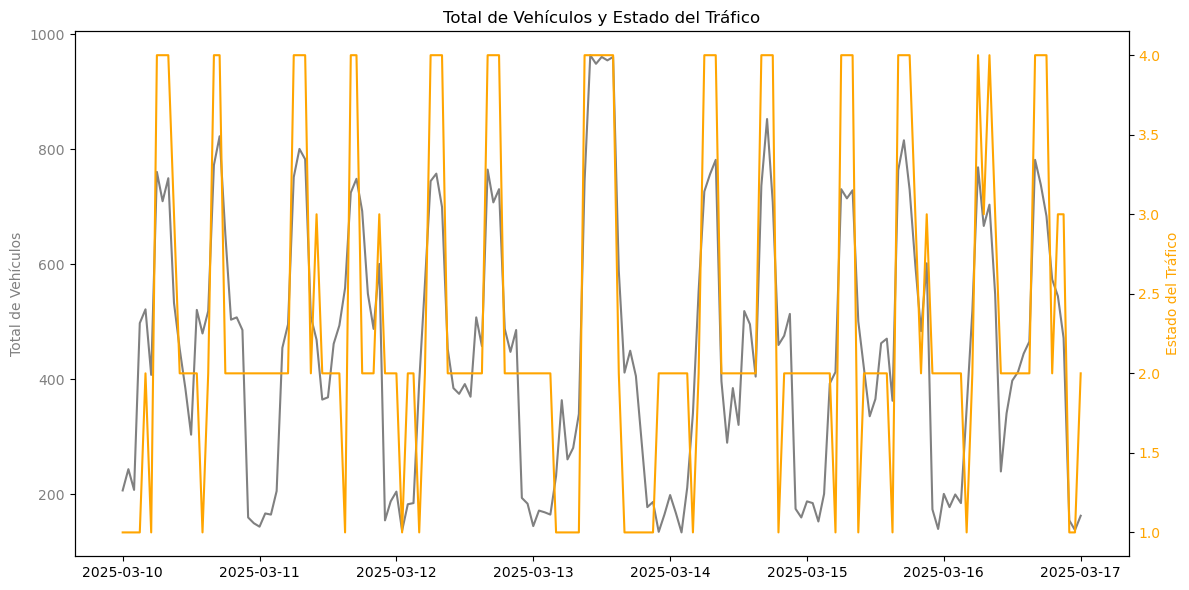

In [298]:
traffic_data_hourly_vec_w = traffic_data_hourly_vec.loc[start_date:end_date]

plt.clf()
# Graficar las predicciones con dos ejes y
fig, ax1 = plt.subplots(figsize=(12, 6))

# Graficar 'Total' en el eje y principal
ax1.plot(traffic_data_hourly_vec_w.index, traffic_data_hourly_vec_w['Total'], label='Total de Vehículos (Predicción)', color='gray')
ax1.set_ylabel('Total de Vehículos', color='gray')
ax1.tick_params(axis='y', labelcolor='gray')

# Crear un segundo eje y para 'TrafficStatus'
ax2 = ax1.twinx()
ax2.plot(traffic_data_hourly_vec_w.index, traffic_data_hourly_vec_w['TrafficStatus'], label='Estado del Tráfico (Predicción)', color='orange')
ax2.set_ylabel('Estado del Tráfico', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')


# Títulos y leyendas
plt.title('Total de Vehículos y Estado del Tráfico')
fig.tight_layout()
plt.show()

In [300]:
# Ajustar el modelo VARMAX
VARMAX_model = VARMAX(traffic_data_hourly_vec, order=(1,  0))  # (p, q): p=autoregresivo, q=media móvil
VARMAX_model_fit = VARMAX_model.fit(disp=False)

# Resumen del modelo


In [301]:
print(VARMAX_model_fit.summary())

                               Statespace Model Results                               
Dep. Variable:     ['Total', 'TrafficStatus']   No. Observations:                  744
Model:                                 VAR(1)   Log Likelihood               -5352.384
                                  + intercept   AIC                          10722.768
Date:                        Wed, 23 Apr 2025   BIC                          10764.276
Time:                                20:28:15   HQIC                         10738.768
Sample:                            03-10-2025                                         
                                 - 04-09-2025                                         
Covariance Type:                          opg                                         
Ljung-Box (L1) (Q):            20.69, 1.33   Jarque-Bera (JB):         21.82, 44.47
Prob(Q):                        0.00, 0.25   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.08, 0.93   Skew

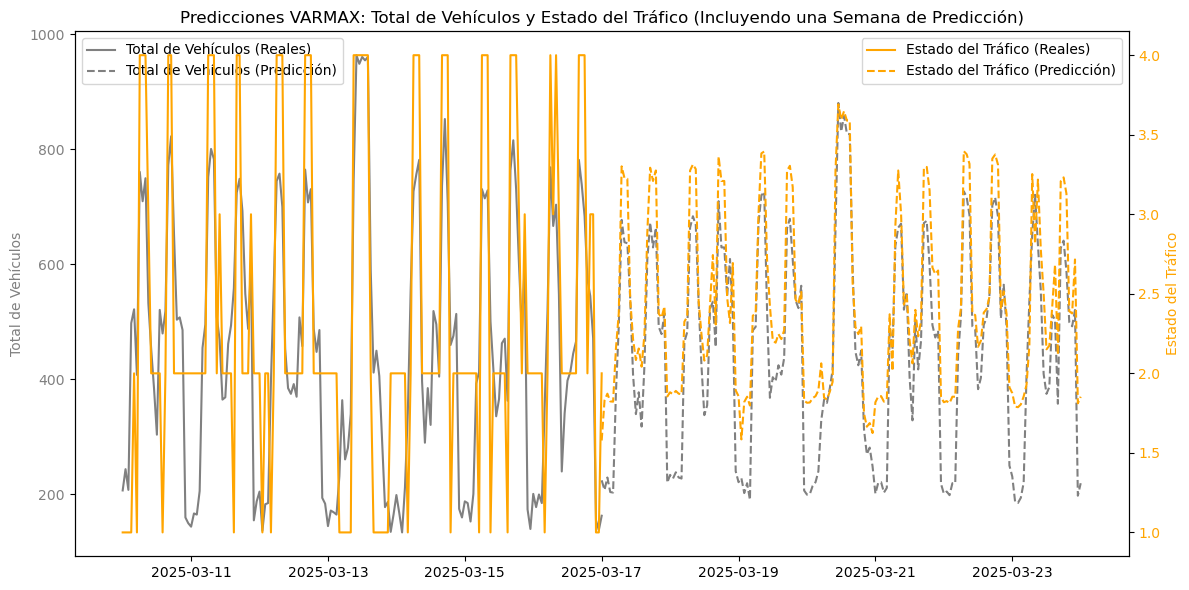

In [302]:
# Usar predict para generar predicciones
predictions = VARMAX_model_fit.predict(start=other_start_date, end=other_end_date)


# Graficar los datos reales y las predicciones con dos ejes y
fig, ax1 = plt.subplots(figsize=(12, 6))

# Graficar 'Total' (valores reales y predicciones) en el eje y principal
ax1.plot(traffic_data_hourly_vec_w.index, traffic_data_hourly_vec_w['Total'], label='Total de Vehículos (Reales)', color='gray')
ax1.plot(predictions.index, predictions['Total'], label='Total de Vehículos (Predicción)', color='gray', linestyle='--')
ax1.set_ylabel('Total de Vehículos', color='gray')
ax1.tick_params(axis='y', labelcolor='gray')

# Crear un segundo eje y para 'TrafficStatus' (valores reales y predicciones)
ax2 = ax1.twinx()
ax2.plot(traffic_data_hourly_vec_w.index, traffic_data_hourly_vec_w['TrafficStatus'], label='Estado del Tráfico (Reales)', color='orange')
ax2.plot(predictions.index, predictions['TrafficStatus'], label='Estado del Tráfico (Predicción)', color='orange', linestyle='--')
ax2.set_ylabel('Estado del Tráfico', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Títulos y leyendas
plt.title('Predicciones VARMAX: Total de Vehículos y Estado del Tráfico (Incluyendo una Semana de Predicción)')
fig.tight_layout()

# Agregar leyendas para ambos ejes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

### Análisis de la gráfica
Vemos que los datos predichos están suavizados. Además VARMAX no nos devuelve valores discretos para el estado del tráfico, por lo que luego para mapear con el label, tenemos que preprocesarlos, de manera de convertirlo a valores 1,2,3,4.

In [303]:
dates_to_check = traffic_data_hourly_vec.index

# Generar predicciones para el rango de fechas
start_date_to_analyze = dates_to_check.min()
end_date_to_analyze = dates_to_check.max()
predictions = VARMAX_model_fit.predict(start=start_date_to_analyze, end=end_date_to_analyze)

# Crear un DataFrame para la comparación
comparison = pd.DataFrame({'Fecha': dates_to_check})

# Agregar valores predichos
comparison['Total (Predicción)'] = predictions.reindex(dates_to_check)['Total'].values
comparison['TrafficStatus (Predicción)'] = predictions.reindex(dates_to_check)['TrafficStatus'].values

# Verificar si los valores reales existen y agregarlos si están disponibles
real_values = traffic_data_hourly_vec.loc[start_date_to_analyze:end_date_to_analyze]
comparison['Total (Real)'] = real_values.reindex(dates_to_check)['Total'].values if not real_values.empty else None
comparison['TrafficStatus (Real)'] = real_values.reindex(dates_to_check)['TrafficStatus'].values if not real_values.empty else None


# Convertir las predicciones y valores reales de TrafficStatus a enteros
comparison['TrafficStatus (Predicción)'] = comparison['TrafficStatus (Predicción)'].round().clip(lower=1, upper=4).astype(int)


# Mapear los valores enteros a etiquetas
comparison['TrafficStatus (Predicción - Label)'] = comparison['TrafficStatus (Predicción)'].map(reverse_traffic_situation_mapping)
if 'TrafficStatus (Real)' in comparison.columns and comparison['TrafficStatus (Real)'].notna().any():
    comparison['TrafficStatus (Real - Label)'] = comparison['TrafficStatus (Real)'].map(reverse_traffic_situation_mapping)



# Mostrar la comparación
print(comparison[['Fecha', 'Total (Predicción)', 'Total (Real)', 'TrafficStatus (Predicción - Label)', 'TrafficStatus (Real - Label)']])

                  Fecha  Total (Predicción)  Total (Real)  \
0   2025-03-10 00:00:00          454.643328         207.0   
1   2025-03-10 01:00:00          286.985089         244.0   
2   2025-03-10 02:00:00          320.421556         208.0   
3   2025-03-10 03:00:00          287.888777         498.0   
4   2025-03-10 04:00:00          549.958382         522.0   
..                  ...                 ...           ...   
739 2025-04-09 19:00:00          707.404907         577.0   
740 2025-04-09 20:00:00          581.956956         464.0   
741 2025-04-09 21:00:00          519.232980         617.0   
742 2025-04-09 22:00:00          578.711686         182.0   
743 2025-04-09 23:00:00          225.000080         168.0   

    TrafficStatus (Predicción - Label) TrafficStatus (Real - Label)  
0                               normal                          low  
1                               normal                          low  
2                               normal                   

In [308]:
# Calcular el MAPE
mape = mean_absolute_percentage_error(valid_rows['Total (Real)'], valid_rows['Total (Predicción)']) * 100
print(f"MAPE: {mape:.2f}%")


MAPE: 29.71%


In [304]:
# Filtrar filas donde existan valores reales y predichos
valid_rows = comparison.dropna(subset=['TrafficStatus (Real - Label)', 'TrafficStatus (Predicción - Label)'])

# Valores reales y predichos
y_true = valid_rows['TrafficStatus (Real - Label)']
y_pred = valid_rows['TrafficStatus (Predicción - Label)']

# Calcular métricas
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')  # 'weighted' para manejar clases desbalanceadas
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')


# Mostrar resultados
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Accuracy: 0.55
Precision: 0.64
Recall: 0.55
F1-Score: 0.51


/opt/anaconda3/envs/Fabricio/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Comparativo de Serie de Tiempo univariada vs Vectorial

In [305]:
# Crear un diccionario con las métricas
metrics_dict = {
    "Accuracy (Vec)": [accuracy],
    "Precision (Vec)": [precision],
    "Recall (Vec)": [recall],
    "F1 Score (Vec)": [f1]
}
# Convertir el diccionario en un DataFrame
metrics_vec_df = pd.DataFrame(metrics_dict)

# Concatenar con el DataFrame existente
metrics_df_vs = pd.concat([metrics_df, metrics_vec_df], axis=1)

# Mostrar el DataFrame
print(metrics_df_vs)

   Accuracy (TS)  Precision (TS)  Recall (TS)  F1 Score (TS)  Accuracy (Vec)  \
0       0.384409        0.634019     0.384409       0.424566        0.549731   

   Precision (Vec)  Recall (Vec)  F1 Score (Vec)  
0         0.639361      0.549731        0.511686  


In [306]:
conf_matrix = confusion_matrix(y_true, y_pred)

<Figure size 640x480 with 0 Axes>

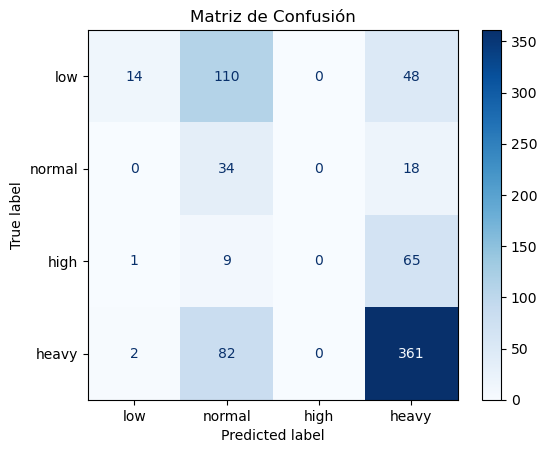

In [307]:
# Crear la matriz de confusión
plt.clf()



# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,  display_labels=list(reverse_traffic_situation_mapping.values()))
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión")
plt.show()

# Conclusiones del bonus track
1. Manteniendo la precisión hemos logrado aumentar el accuracy, recall y F1 Score. Por el contrario obtenemos un peor MAPE que el mejor modelo univariado para predecir la cantidad de vehículos en la autopista.

2. Podemos ver en la gráfica que los valores predichos están suavizados, sobre todo para el TrafficStatus. Quizás escalando los datos, buscando modelos más complejos podamos quebrar esa suavidad y lograr mejores predicciones.